# This file uses the features_labeled_majorColumn.csv with Major column

---



In [1]:
!pip install noisereduce
!pip install praat-parselmouth
!pip install --upgrade librosa
!pip install librosa scipy
!pip install pysptk
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysptk: filename=pysptk-1.0.1-cp310-cp310-linux_x86_64.whl size=1241916 sha256=2e4b08f93504fe1fe518e1940ff460b2bd934f26b57afa5a8b14548b3bc6c34a
  Stored in directory: /root/.cache/pip/wheels/ba/c2/7f/73c54e1795eeca8f995f95474c8290b78ee0a6306412dc934f
Successfully built pysptk


In [2]:
import numpy as np
import os
import pandas as pd
import re
import librosa
import parselmouth
from parselmouth.praat import call
import scipy.stats as stats
import scipy
import pysptk
from scipy.io import wavfile
from tqdm import tqdm
from google.colab import drive

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Proceed with splitting the data and training the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Google Colab specific
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


## Load File

In [6]:
df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP/IEMOCAP_MAJOR_LABELLED.csv')
#df.dropna(subset=['Major'], inplace=True)
df.head()

,Session,Conversation,Audio_Path,Speaker_id,Transcript,Time_Frame,Audio_Uttrance_Path,category,most_repeated_label
0,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M001,I wonder.,008.6300-009.6700,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Fear', 'Excited']",fear
1,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M002,It must be them then.,011.4300-012.7900,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Fear', 'Excited']",fear
2,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F005,Ahh. It sent shivers up my spine.,025.9111-030.4663,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Frustration', 'Excited', 'Excited']",excited
3,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M006,What shall we do if they suddenly walk in on us?,029.8095-033.1781,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Frustration', 'Excited', 'Excited']",excited
4,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F006,Behave exquisitely.,032.8800-034.9200,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Excited', 'Happiness', 'Excited']",excited


In [24]:
merged_df = df[['Speaker_id', 'Transcript', 'most_repeated_label']].rename(columns={'most_repeated_label': 'Emotion'})
emotion_mapping = {
    'neutral': 'neutral',
    'frustration': None,
    'anger': 'angry',
    'surprise': None,  # Assuming 'Surprise' to 'neutral' if not sure where to map
    'disgust': None,  # Mapping 'Disgust' to 'angry' or consider removing if not relevant
    'other': None,  # Remove 'Other' or map if it can be categorized
    'sadness': 'sad',
    'fear': None,  # Assuming 'Fear' to 'neutral' or map to 'angry' based on context
    'happiness': 'happy',
    'excited': 'happy'
}
# Apply the mapping to the Emotion column
merged_df['Emotion'] = merged_df['Emotion'].map(emotion_mapping)
# Remove any rows with None as Emotion (unmapped categories)
merged_df = merged_df.dropna(subset=['Emotion'])
merged_df.head()

,Speaker_id,Transcript,Emotion
2,Ses04F_script03_1_F005,Ahh. It sent shivers up my spine.,happy
3,Ses04F_script03_1_M006,What shall we do if they suddenly walk in on us?,happy
4,Ses04F_script03_1_F006,Behave exquisitely.,happy
5,Ses04F_script03_1_M007,With the most perfect poise.,happy
6,Ses04F_script03_1_F007,Certainly I shall probably do a court curtsy.,happy


In [25]:
merged_df['Emotion'] = merged_df['Emotion'].replace('excited', 'happy')
merged_df = merged_df[~merged_df['Emotion'].str.contains('nervous', na=False)]


In [26]:
# Recalculate the emotion counts
emotion_counts = merged_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

happy: 1760
neutral: 1710
sad: 1075
angry: 1042


In [27]:
stop_words = set(stopwords.words('english'))
# Consider removing negations from the stopword list if they are crucial for emotion detection
negations = {"not", "no", "never", "none", "nothing", "neither", "nowhere", "hardly", "scarcely", "barely", "don’t", "isn’t", "wasn’t", "shouldn’t", "wouldn’t", "couldn’t", "won’t"}
stop_words = stop_words - negations

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase to standardize the text
    text = text.lower()
    '''
    # Split text into words
    words = text.split()

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Rejoin words to form the cleaned text
    text = ' '.join(filtered_words)
    '''
    return text

# Apply the preprocessing function to the 'Transcript' column
merged_df['Transcript'] = merged_df['Transcript'].apply(preprocess_text)

# Display the first few entries to verify changes
merged_df.head()


,Speaker_id,Transcript,Emotion
2,Ses04F_script03_1_F005,ahh. it sent shivers up my spine.,happy
3,Ses04F_script03_1_M006,what shall we do if they suddenly walk in on us?,happy
4,Ses04F_script03_1_F006,behave exquisitely.,happy
5,Ses04F_script03_1_M007,with the most perfect poise.,happy
6,Ses04F_script03_1_F007,certainly i shall probably do a court curtsy.,happy


In [28]:

# Assuming 'merged_df' is your DataFrame containing the 'Emotion' and 'Transcript' columns

# Text preprocessing
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(merged_df['Transcript'])
y = merged_df['Emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5948121645796064
              precision    recall  f1-score   support

       angry       0.61      0.52      0.56       193
       happy       0.65      0.67      0.66       360
     neutral       0.52      0.61      0.56       333
         sad       0.65      0.51      0.57       232

    accuracy                           0.59      1118
   macro avg       0.60      0.58      0.59      1118
weighted avg       0.60      0.59      0.59      1118



In [29]:

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# Apply the vectorizer to the Transcript column
X = vectorizer.fit_transform(merged_df['Transcript'])
y = merged_df['Emotion']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict the emotions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5957066189624329
              precision    recall  f1-score   support

       angry       0.68      0.54      0.61       193
       happy       0.68      0.61      0.64       360
     neutral       0.50      0.69      0.58       333
         sad       0.63      0.48      0.54       232

    accuracy                           0.60      1118
   macro avg       0.62      0.58      0.59      1118
weighted avg       0.61      0.60      0.60      1118



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# Bulding Deep Models

In [30]:
merged_df['Transcript'].apply(lambda x: len(x.split())).max()

98

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Generate an array of indices the same length as dataset
# Text tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(merged_df['Transcript'])
sequences = tokenizer.texts_to_sequences(merged_df['Transcript'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
indices = np.arange(padded_sequences.shape[0])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    padded_sequences, y, indices, test_size=0.2, random_state=42)

In [33]:

# Initialize the Adam optimizer with a custom learning rate
learning_rate = 0.001  # You can adjust this value
optimizer = Adam(learning_rate=learning_rate)


In [32]:


def evaluate_model(model, X_test, y_test, history, class_labels):
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_acc)

    # Predict the test set results for F1 and Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute the F1 Score
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print("F1 Score:", f1)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print(classification_report(y_true_classes, y_pred_classes))

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()




In [34]:
def model_1(vocab_size, output_size):
    tf.random.set_seed(42)
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=40, input_length=85),
        Bidirectional(LSTM(100)),
        Dense(output_size, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [35]:


vocab_size = 10000  # or len(tokenizer.word_index) + 1
output_size = len(encoder.classes_)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
# Initialize the model
model = model_1(vocab_size, output_size)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.3360 - loss: 1.3523 - val_accuracy: 0.4821 - val_loss: 1.1910
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5196 - loss: 1.1072 - val_accuracy: 0.5662 - val_loss: 1.0561
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.6510 - loss: 0.8506 - val_accuracy: 0.5930 - val_loss: 1.0409
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.7177 - loss: 0.7015 - val_accuracy: 0.5993 - val_loss: 1.0805
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.7683 - loss: 0.6104 - val_accuracy: 0.6100 - val_loss: 1.0855
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.7926 - loss: 0.5479 - val_accuracy: 0.6154 - val_loss: 1.1332
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8083 - loss: 0.5000 - val_accuracy: 0.6199 - val_loss: 1.2037
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8122 - loss: 0.4734 - val_accurac

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5836 - loss: 1.0680
Test Accuracy: 0.5930232405662537
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
F1 Score: 0.5842164292307732
Confusion Matrix:
 [[106  19  61   7]
 [ 12 239  90  19]
 [ 23  48 245  17]
 [  8  58  93  73]]
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       193
           1       0.66      0.66      0.66       360
           2       0.50      0.74      0.60       333
           3       0.63      0.31      0.42       232

    accuracy                           0.59      1118
   macro avg       0.62      0.57      0.57      1118
weighted avg       0.61      0.59      0.58      1118



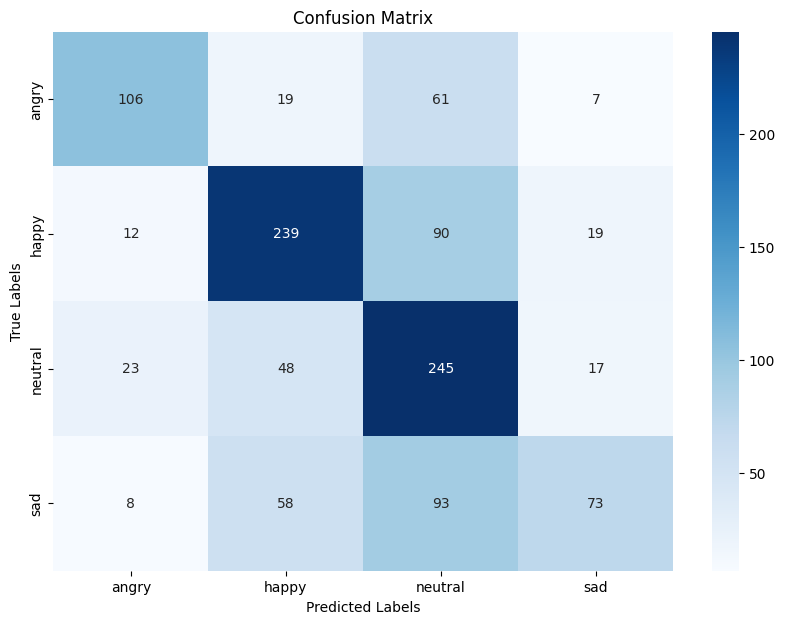

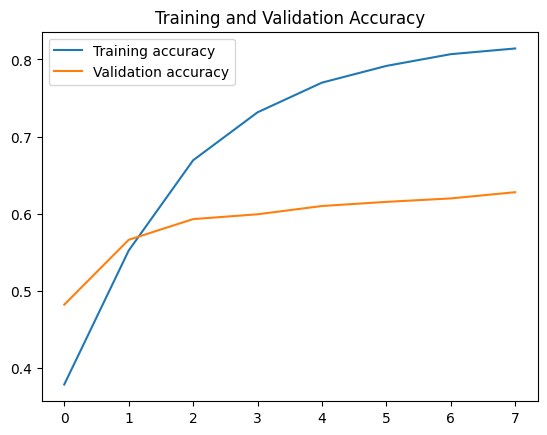

In [36]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


### Attention

In [37]:

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        # Applying the attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)


def build_model(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85),
        Bidirectional(LSTM(100, return_sequences=True)),
        Attention(return_sequences=False),  # Use attention mechanism
        Dense(64, activation='relu'),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Example usage
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
model = build_model(vocab_size=10000, output_size=4)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.3054 - loss: 1.3650 - val_accuracy: 0.2979 - val_loss: 1.3684
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.3216 - loss: 1.3393 - val_accuracy: 0.3730 - val_loss: 1.2869
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.4242 - loss: 1.2190 - val_accuracy: 0.4249 - val_loss: 1.1889
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.5127 - loss: 1.0664 - val_accuracy: 0.5134 - val_loss: 1.1262
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5840 - loss: 0.9303 - val_accuracy: 0.5626 - val_loss: 1.0926
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.6889 - loss: 0.7720 - val_accuracy: 0.5877 - val_loss: 1.0795
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.7501 - loss: 0.6389 - val_accuracy: 0.6100 - val_loss: 1.1108
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.7861 - loss: 0.5743 - val_accura

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6189 - loss: 2.5766
Test Accuracy: 0.6234347224235535
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
F1 Score: 0.6238275795041531
Confusion Matrix:
 [[138  12  28  15]
 [ 18 223  87  32]
 [ 51  49 202  31]
 [ 18  36  44 134]]
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       193
           1       0.70      0.62      0.66       360
           2       0.56      0.61      0.58       333
           3       0.63      0.58      0.60       232

    accuracy                           0.62      1118
   macro avg       0.63      0.63      0.63      1118
weighted avg       0.63      0.62      0.62      1118



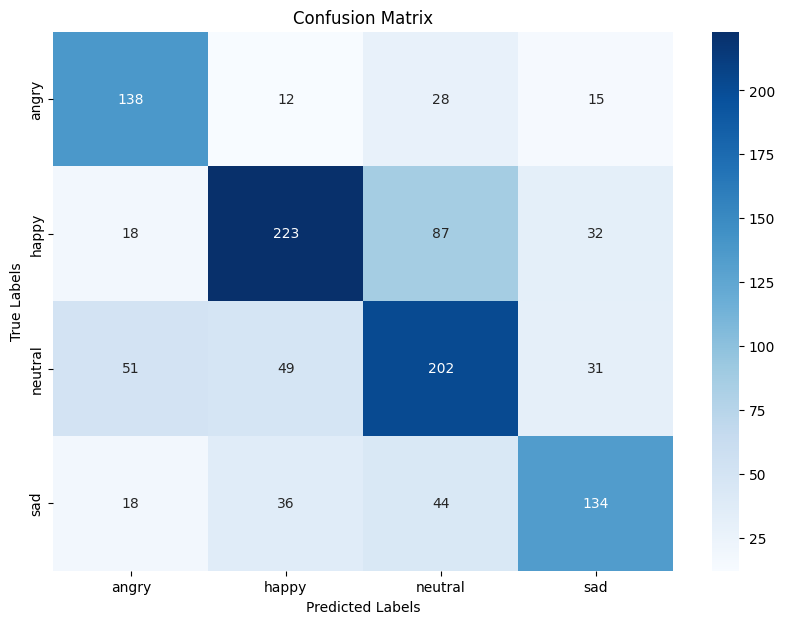

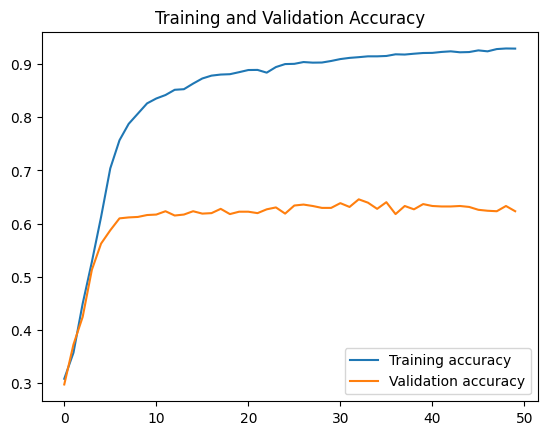

In [38]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


In [39]:

speaker_ids_test = merged_df.iloc[idx_test]['Speaker_id'].tolist()

def evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids):
    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Fetch transcripts and speaker_ids based on test indices
    transcripts = merged_df.iloc[idx_test]['Transcript'].tolist()

    # Convert numeric labels back to original labels
    predicted_labels = [class_labels[i] for i in y_pred_classes]
    true_labels = [class_labels[i] for i in y_true_classes]

    # Create a DataFrame to display the speaker_id, transcripts, true labels, predicted labels
    results_df = pd.DataFrame({
        'Speaker ID': speaker_ids,
        'Transcript': transcripts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels,
        'Predicted Probability': np.max(y_pred, axis=1)
    })



    return results_df  # Return the DataFrame in case you need it for further analysis

# Usage of the function
class_labels = encoder.classes_
results_df = evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids_test)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [40]:
# Display the DataFrame
results_df

,Speaker ID,Transcript,True Label,Predicted Label,Predicted Probability
0,Ses03M_impro05a_F024,"yes. well, because--",neutral,neutral,0.887023
1,Ses01F_impro07_M006,a rapper party ho. yeah. okay.,happy,happy,0.971467
2,Ses04F_impro03_F043,i know. i've been waiting forever. i can't b...,happy,neutral,0.991364
3,Ses04F_script03_2_F035,you're far too temperamental. try to control ...,angry,angry,1.000000
4,Ses04M_script01_3_M032,there was no meaning in it here. the whole th...,sad,sad,1.000000
...,...,...,...,...,...
1113,Ses01F_script02_1_F006,you keep saying my flashlight like it's just y...,angry,neutral,0.999793
1114,Ses05F_script03_1_M011,what does it all mean? that's what i asked my...,happy,happy,1.000000
1115,Ses02F_script01_2_M017,look at you. look at you shaking.,angry,angry,0.998211
1116,Ses05M_impro02_M028,"all- i'll write you everyday, all the time. a...",sad,sad,0.998990


# **Model 2**

In [41]:
def build_model_2(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85, trainable=True),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Attention(return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [43]:
model2 = build_model_2(vocab_size=10000, output_size=4)
history = model2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 209ms/step - accuracy: 0.3139 - loss: 1.3678 - val_accuracy: 0.2987 - val_loss: 1.3627
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.3321 - loss: 1.3375 - val_accuracy: 0.3989 - val_loss: 1.2716
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.4431 - loss: 1.1655 - val_accuracy: 0.4982 - val_loss: 1.1563
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.5894 - loss: 0.9705 - val_accuracy: 0.5894 - val_loss: 1.0431
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - accuracy: 0.6743 - loss: 0.7973 - val_accuracy: 0.6029 - val_loss: 1.0539
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.7226 - loss: 0.7150 - val_accuracy: 0.6038 - val_loss: 1.0463
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.7652 - loss: 0.6373 - val_accuracy: 0.6154 - val_loss: 1.0668
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.7924 - loss: 0.5752 - val

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6328 - loss: 3.1172
Test Accuracy: 0.6279069781303406
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
F1 Score: 0.628374402751318
Confusion Matrix:
 [[137  10  37   9]
 [ 24 229  84  23]
 [ 49  50 208  26]
 [ 18  42  44 128]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       193
           1       0.69      0.64      0.66       360
           2       0.56      0.62      0.59       333
           3       0.69      0.55      0.61       232

    accuracy                           0.63      1118
   macro avg       0.63      0.63      0.63      1118
weighted avg       0.64      0.63      0.63      1118



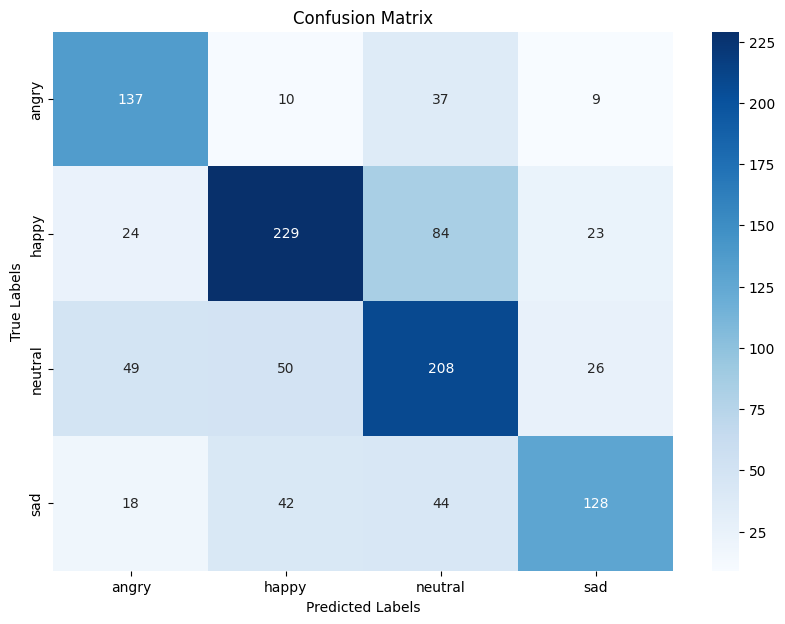

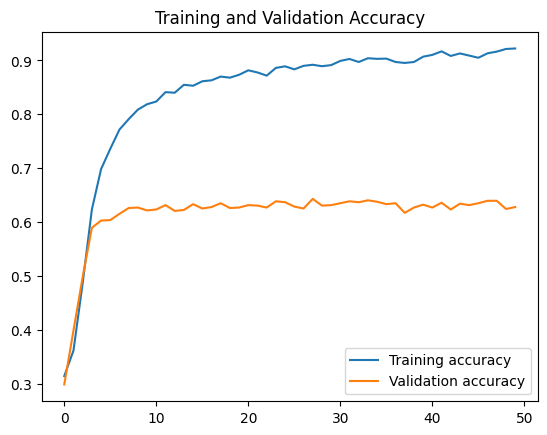

In [44]:
evaluate_model(model2, X_test, y_test, history, encoder.classes_)


# Word2Vec embeddings

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec

# Prepare the Word2Vec embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged_df['Transcript'])
sequences = tokenizer.texts_to_sequences(merged_df['Transcript'])
word_index = tokenizer.word_index
reversed_word_map = dict(map(reversed, tokenizer.word_index.items()))
sentences = [[reversed_word_map.get(letter) for letter in seq] for seq in sequences]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    try:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue  # Words not found in the embedding index will be all-zeros.

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert sequences to padded sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare the data matrix X
X = np.zeros((len(padded_sequences), max_length, 100))  # assuming each Word2Vec vector is 100-dimensional
for i, sequence in enumerate(padded_sequences):
    for j, index in enumerate(sequence):
        X[i, j] = embedding_matrix[index] if index > 0 else np.zeros(100)

In [47]:
def evaluate_model(model, X_test, y_test, history, class_labels):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    #print("Test Accuracy:", test_acc)
    #accuracies.append(test_acc)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    #print("F1 Score:", f1)
    #f1_scores.append(f1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(classification_report(y_true_classes, y_pred_classes))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return test_acc, f1, cm

Training fold 1
Epoch 1/100
140/140 - 16s - 114ms/step - accuracy: 0.3793 - loss: 1.3128 - val_accuracy: 0.4705 - val_loss: 1.2034
Epoch 2/100
140/140 - 20s - 141ms/step - accuracy: 0.5397 - loss: 1.0763 - val_accuracy: 0.5465 - val_loss: 1.0796
Epoch 3/100
140/140 - 11s - 80ms/step - accuracy: 0.6670 - loss: 0.8379 - val_accuracy: 0.6020 - val_loss: 1.0053
Epoch 4/100
140/140 - 11s - 80ms/step - accuracy: 0.7346 - loss: 0.7000 - val_accuracy: 0.6082 - val_loss: 1.0147
Epoch 5/100
140/140 - 19s - 138ms/step - accuracy: 0.7702 - loss: 0.6052 - val_accuracy: 0.6190 - val_loss: 1.0899
Epoch 6/100
140/140 - 11s - 79ms/step - accuracy: 0.7879 - loss: 0.5492 - val_accuracy: 0.6386 - val_loss: 1.0812
Epoch 7/100
140/140 - 21s - 148ms/step - accuracy: 0.8022 - loss: 0.5084 - val_accuracy: 0.6377 - val_loss: 1.0538
Epoch 8/100
140/140 - 20s - 146ms/step - accuracy: 0.8152 - loss: 0.4724 - val_accuracy: 0.6288 - val_loss: 1.1743
Epoch 9/100
140/140 - 20s - 145ms/step - accuracy: 0.8235 - loss: 0

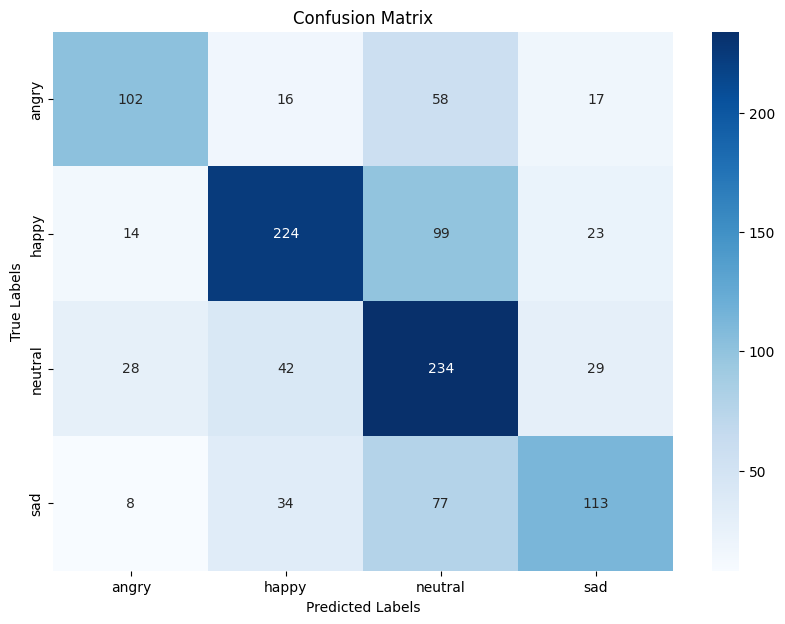

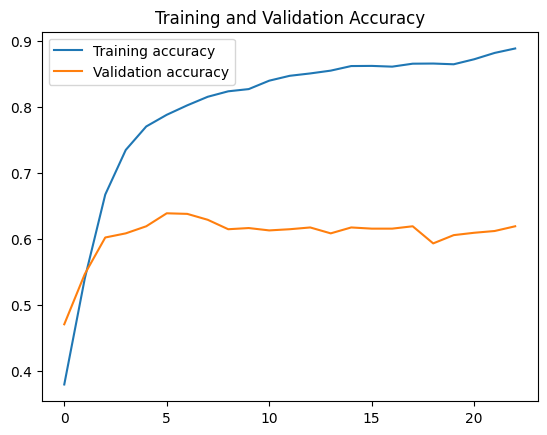

Tet Accuracy: 0.6019678115844727
F1 Score: 0.6027824342891034
Confusion Matrix:
 [[102  16  58  17]
 [ 14 224  99  23]
 [ 28  42 234  29]
 [  8  34  77 113]]
*********************************************
Training fold 2
Epoch 1/100
140/140 - 16s - 112ms/step - accuracy: 0.3513 - loss: 1.3446 - val_accuracy: 0.4365 - val_loss: 1.2867
Epoch 2/100
140/140 - 19s - 136ms/step - accuracy: 0.4876 - loss: 1.1797 - val_accuracy: 0.5456 - val_loss: 1.0890
Epoch 3/100
140/140 - 11s - 80ms/step - accuracy: 0.6391 - loss: 0.9157 - val_accuracy: 0.6020 - val_loss: 0.9830
Epoch 4/100
140/140 - 11s - 80ms/step - accuracy: 0.7098 - loss: 0.7414 - val_accuracy: 0.6145 - val_loss: 0.9664
Epoch 5/100
140/140 - 19s - 138ms/step - accuracy: 0.7527 - loss: 0.6356 - val_accuracy: 0.6154 - val_loss: 1.0228
Epoch 6/100
140/140 - 11s - 76ms/step - accuracy: 0.7872 - loss: 0.5602 - val_accuracy: 0.6386 - val_loss: 1.0267
Epoch 7/100
140/140 - 21s - 149ms/step - accuracy: 0.8089 - loss: 0.5076 - val_accuracy: 0.63

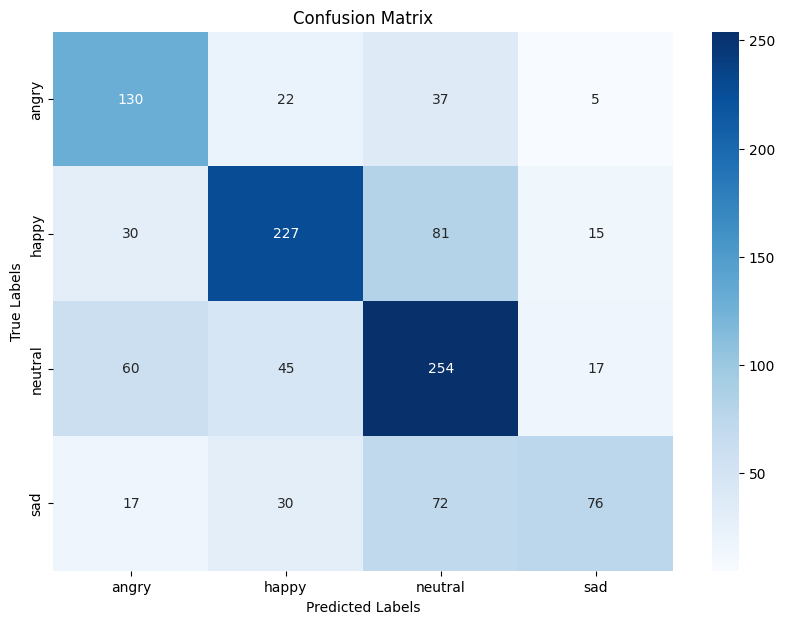

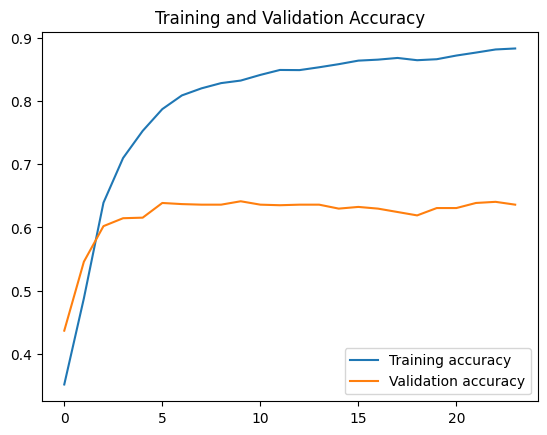

Tet Accuracy: 0.6144901514053345
F1 Score: 0.6108446291601893
Confusion Matrix:
 [[130  22  37   5]
 [ 30 227  81  15]
 [ 60  45 254  17]
 [ 17  30  72  76]]
*********************************************
Training fold 3
Epoch 1/100
140/140 - 16s - 114ms/step - accuracy: 0.3539 - loss: 1.3270 - val_accuracy: 0.3930 - val_loss: 1.2923
Epoch 2/100
140/140 - 19s - 139ms/step - accuracy: 0.5450 - loss: 1.0830 - val_accuracy: 0.5551 - val_loss: 1.0417
Epoch 3/100
140/140 - 21s - 151ms/step - accuracy: 0.6705 - loss: 0.8257 - val_accuracy: 0.6052 - val_loss: 0.9608
Epoch 4/100
140/140 - 13s - 89ms/step - accuracy: 0.7407 - loss: 0.6853 - val_accuracy: 0.6168 - val_loss: 0.9772
Epoch 5/100
140/140 - 21s - 147ms/step - accuracy: 0.7776 - loss: 0.5966 - val_accuracy: 0.6240 - val_loss: 1.0244
Epoch 6/100
140/140 - 20s - 143ms/step - accuracy: 0.7984 - loss: 0.5315 - val_accuracy: 0.6240 - val_loss: 1.1188
Epoch 7/100
140/140 - 21s - 149ms/step - accuracy: 0.8123 - loss: 0.4911 - val_accuracy: 0.

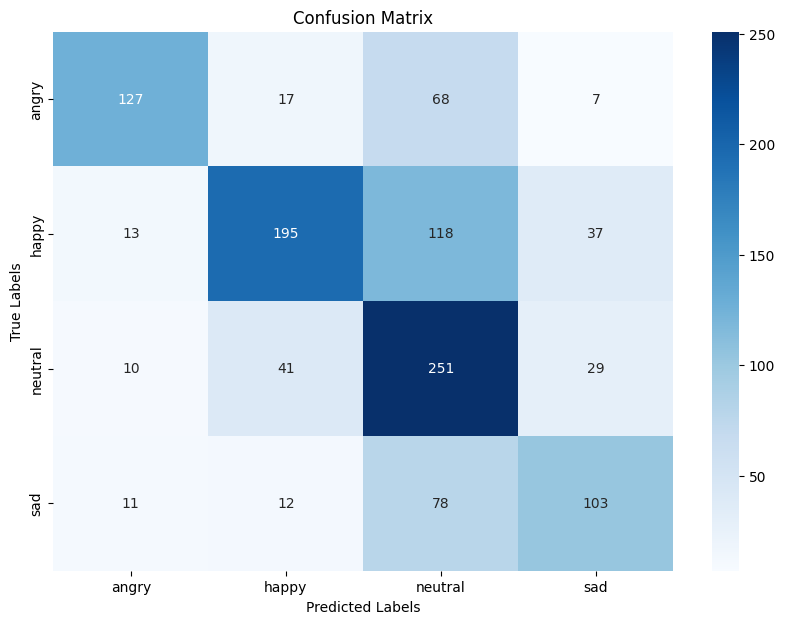

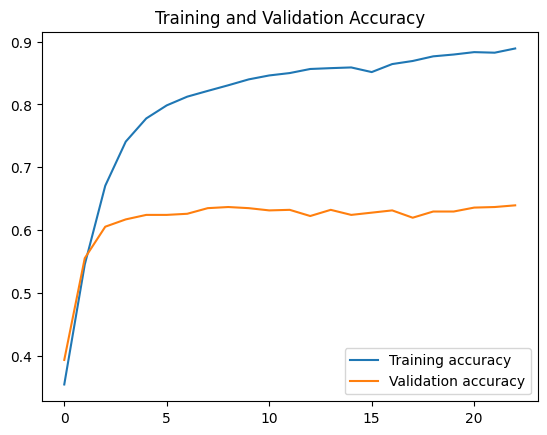

Tet Accuracy: 0.6051924824714661
F1 Score: 0.6077104780374176
Confusion Matrix:
 [[127  17  68   7]
 [ 13 195 118  37]
 [ 10  41 251  29]
 [ 11  12  78 103]]
*********************************************
Training fold 4
Epoch 1/100
140/140 - 14s - 100ms/step - accuracy: 0.3796 - loss: 1.3199 - val_accuracy: 0.4718 - val_loss: 1.2145
Epoch 2/100
140/140 - 11s - 80ms/step - accuracy: 0.5817 - loss: 1.0222 - val_accuracy: 0.5712 - val_loss: 1.0223
Epoch 3/100
140/140 - 20s - 144ms/step - accuracy: 0.6839 - loss: 0.8164 - val_accuracy: 0.6294 - val_loss: 0.9438
Epoch 4/100
140/140 - 11s - 81ms/step - accuracy: 0.7434 - loss: 0.6842 - val_accuracy: 0.6482 - val_loss: 0.9386
Epoch 5/100
140/140 - 20s - 145ms/step - accuracy: 0.7765 - loss: 0.5951 - val_accuracy: 0.6473 - val_loss: 0.9929
Epoch 6/100
140/140 - 19s - 139ms/step - accuracy: 0.8013 - loss: 0.5297 - val_accuracy: 0.6455 - val_loss: 1.0388
Epoch 7/100
140/140 - 11s - 79ms/step - accuracy: 0.8177 - loss: 0.4818 - val_accuracy: 0.64

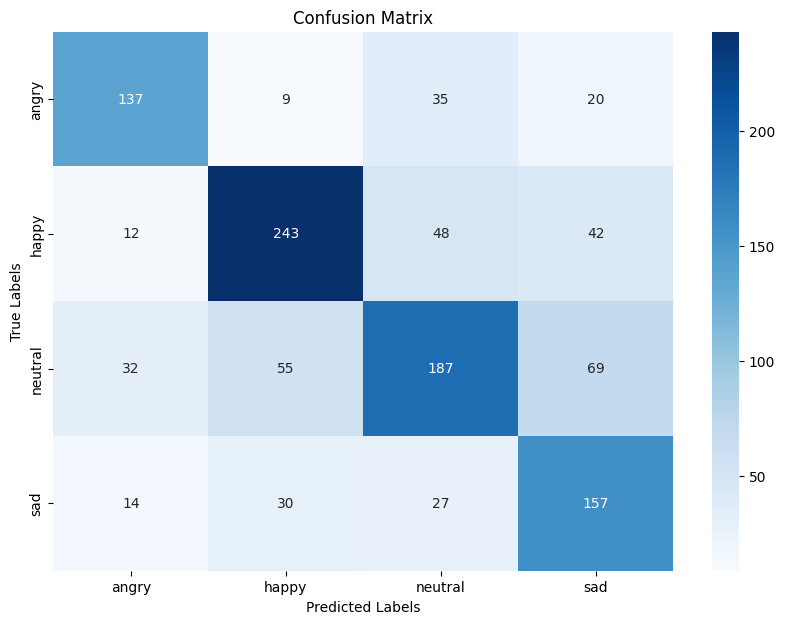

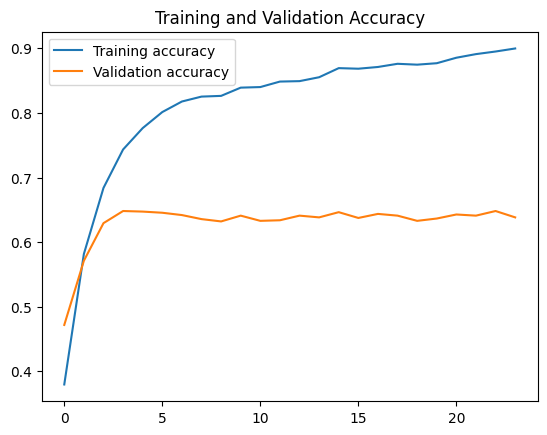

Tet Accuracy: 0.6481647491455078
F1 Score: 0.6482641078826923
Confusion Matrix:
 [[137   9  35  20]
 [ 12 243  48  42]
 [ 32  55 187  69]
 [ 14  30  27 157]]
*********************************************
Training fold 5
Epoch 1/100
140/140 - 14s - 98ms/step - accuracy: 0.3743 - loss: 1.3228 - val_accuracy: 0.4217 - val_loss: 1.2566
Epoch 2/100
140/140 - 19s - 138ms/step - accuracy: 0.5445 - loss: 1.0813 - val_accuracy: 0.5658 - val_loss: 1.0497
Epoch 3/100
140/140 - 21s - 150ms/step - accuracy: 0.6485 - loss: 0.8834 - val_accuracy: 0.6276 - val_loss: 0.9570
Epoch 4/100
140/140 - 21s - 148ms/step - accuracy: 0.7136 - loss: 0.7147 - val_accuracy: 0.6204 - val_loss: 0.9631
Epoch 5/100
140/140 - 11s - 79ms/step - accuracy: 0.7584 - loss: 0.6198 - val_accuracy: 0.6258 - val_loss: 0.9797
Epoch 6/100
140/140 - 21s - 147ms/step - accuracy: 0.7872 - loss: 0.5528 - val_accuracy: 0.6258 - val_loss: 1.0246
Epoch 7/100
140/140 - 11s - 79ms/step - accuracy: 0.8094 - loss: 0.5012 - val_accuracy: 0.61

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.65      0.30      0.41       235
           1       0.60      0.32      0.41       339
           2       0.35      0.90      0.51       327
           3       0.00      0.00      0.00       216

    accuracy                           0.42      1117
   macro avg       0.40      0.38      0.33      1117
weighted avg       0.42      0.42      0.36      1117



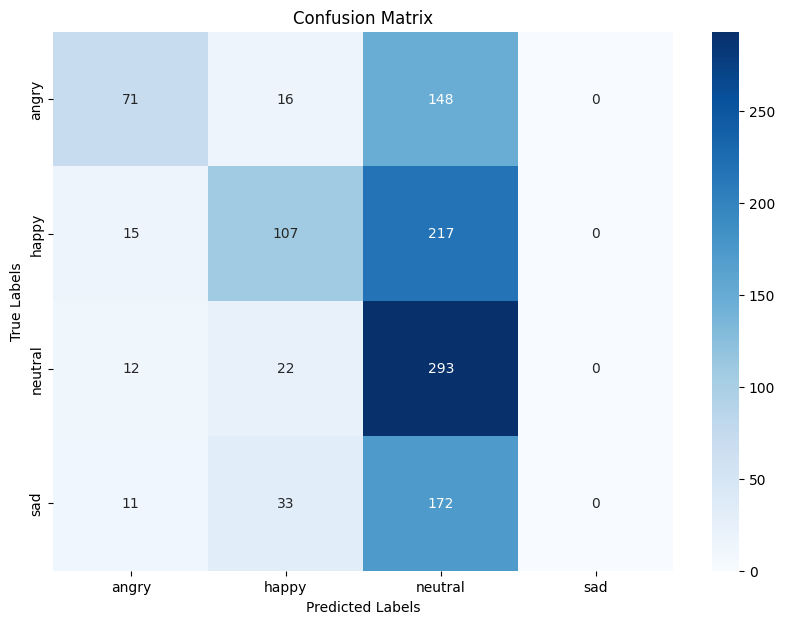

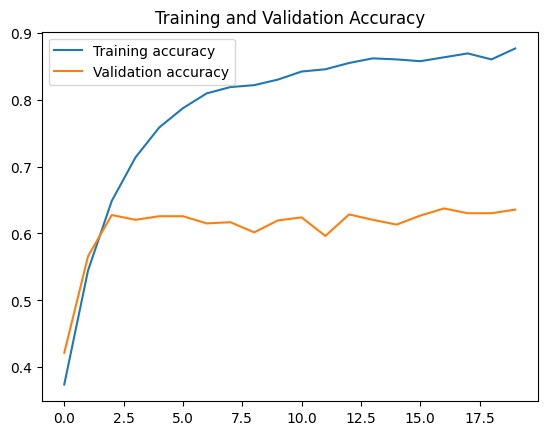

Tet Accuracy: 0.42166516184806824
F1 Score: 0.36074002082560025
Confusion Matrix:
 [[ 71  16 148   0]
 [ 15 107 217   0]
 [ 12  22 293   0]
 [ 11  33 172   0]]
*********************************************
Average F1 Score across all folds: 0.5660683340390006
Average Accuracy across all folds: 0.5782960712909698


In [48]:

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        # Applying the attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

'''
def build_model():
    vocab_size, embedding_dim = embedding_matrix.shape
    model = Sequential([
        # Embedding layer expects integer indices
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],  trainable=False),
        Bidirectional(LSTM(100, return_sequences=True)),
        Attention(return_sequences=False),  # Ensure Attention class is correctly implemented
        Dense(64, activation='relu'),
        Dense(y.shape[1], activation='softmax')  # Adjust the number of output classes dynamically
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
'''
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
vocab_size = 10000  # or len(tokenizer.word_index) + 1
output_size = len(encoder.classes_)
def build_model():
    vocab_size, embedding_dim = embedding_matrix.shape
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=40),
        Bidirectional(LSTM(100)),
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X = padded_sequences
# Setup K-Fold Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the model
    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, verbose = 2, callbacks=[early_stopping])

    # Evaluate the model
    print(f'Evaluating fold {fold_no}')
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')
# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


# BERT EMBEDDING

In [49]:
! pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 4.7 MB/s eta 0:00:00


In [50]:
def evaluate_model(model, X_test, y_test, history, class_labels):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    #print("Test Accuracy:", test_acc)
    #accuracies.append(test_acc)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    #print("F1 Score:", f1)
    #f1_scores.append(f1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(classification_report(y_true_classes, y_pred_classes))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return test_acc, f1, cm

In [51]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # This is a smaller, faster version but still effective.
# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding
output_size = len(encoder.classes_)

# Generate embeddings
transcripts = merged_df['Transcript'].tolist()
embeddings = model.encode(transcripts, show_progress_bar=True)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/175 [00:00<?, ?it/s]

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4019 - loss: 1.2949 - val_accuracy: 0.5233 - val_loss: 1.0998
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5933 - loss: 0.9841 - val_accuracy: 0.5671 - val_loss: 1.0263
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6494 - loss: 0.8479 - val_accuracy: 0.5778 - val_loss: 1.0065
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7130 - loss: 0.7404 - val_accuracy: 0.6127 - val_loss: 0.9791
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7535 - loss: 0.6441 - val_accuracy: 0.6243 - val_loss: 0.9696
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7963 - loss: 0.5458 - val_accuracy: 0.6306 - val_loss: 0.9923
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8183 - loss: 0.4733 - val_accuracy: 0.6288 - val_loss: 1.0087
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8556 - loss: 0.4005 - val_accuracy: 0.6369

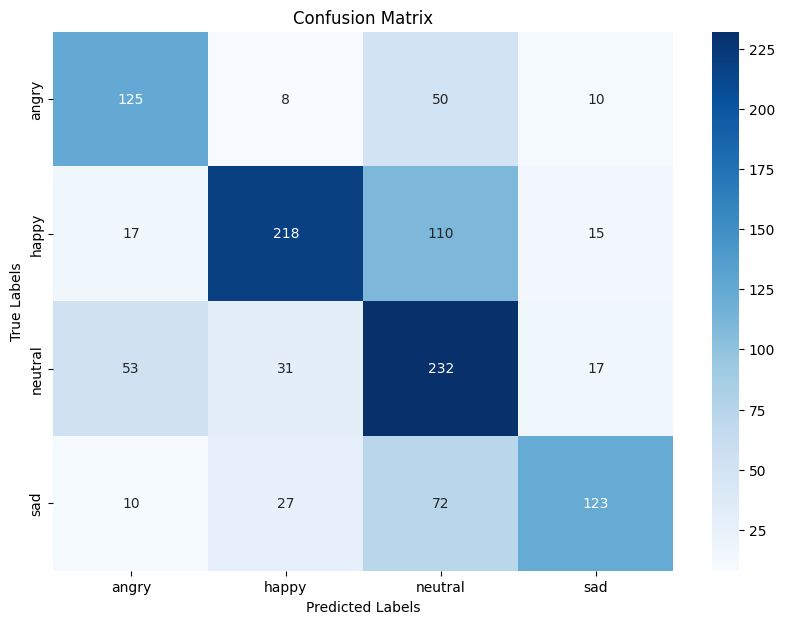

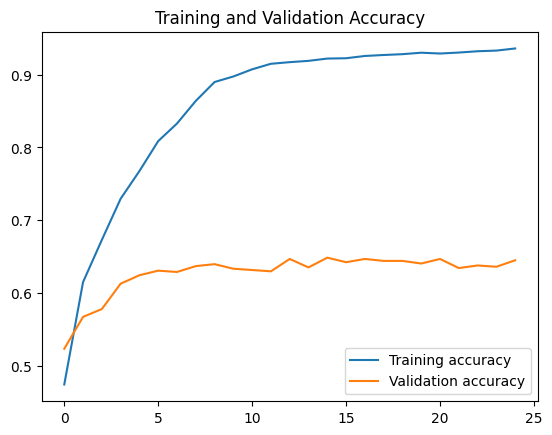

Tet Accuracy: 0.624329149723053
F1 Score: 0.6284284897192475
Confusion Matrix:
 [[125   8  50  10]
 [ 17 218 110  15]
 [ 53  31 232  17]
 [ 10  27  72 123]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3970 - loss: 1.2871 - val_accuracy: 0.5850 - val_loss: 1.0250
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5904 - loss: 0.9921 - val_accuracy: 0.6154 - val_loss: 0.9460
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6546 - loss: 0.8612 - val_accuracy: 0.6386 - val_loss: 0.9021
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7125 - loss: 0.7538 - val_accuracy: 0.6556 - val_loss: 0.8828
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7577 - loss: 0.6477 - val_accuracy: 0.6628 - val_loss: 0.8581
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7918 - loss: 0.5504 - val_accuracy: 0.6530 - val_loss: 0.8677
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.4581 - val_accuracy: 0.6592 - val_loss: 0.9024
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.3974 - val_accuracy: 0.6664

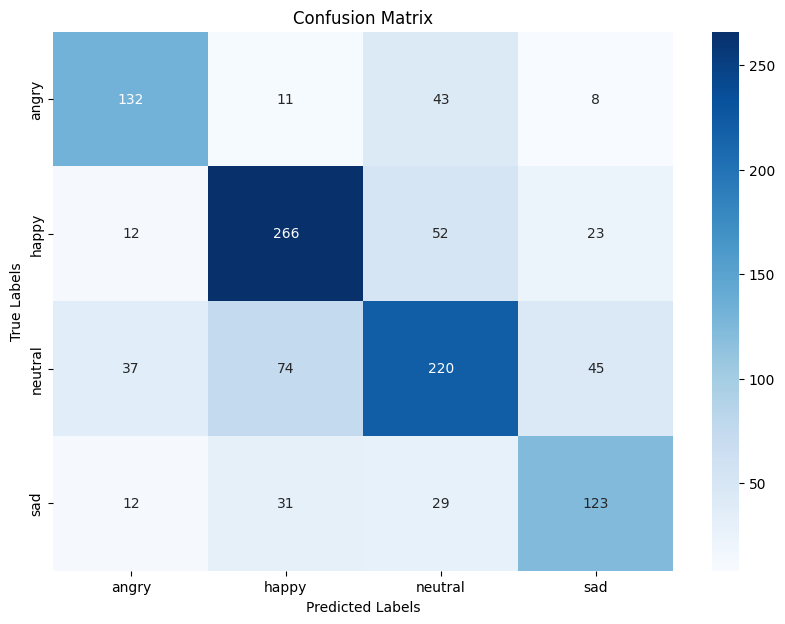

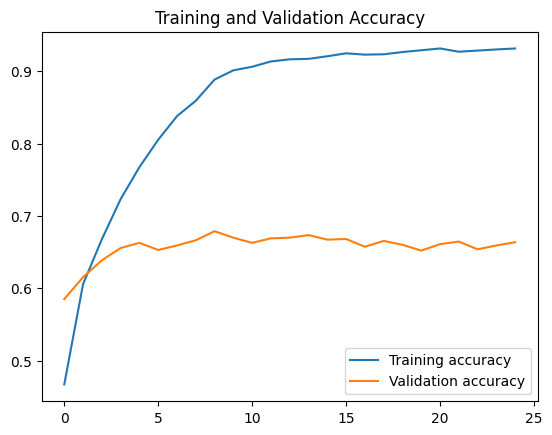

Tet Accuracy: 0.6627907156944275
F1 Score: 0.6613371144806713
Confusion Matrix:
 [[132  11  43   8]
 [ 12 266  52  23]
 [ 37  74 220  45]
 [ 12  31  29 123]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4118 - loss: 1.2889 - val_accuracy: 0.5649 - val_loss: 1.0280
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5985 - loss: 0.9794 - val_accuracy: 0.6150 - val_loss: 0.9397
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6749 - loss: 0.8290 - val_accuracy: 0.6365 - val_loss: 0.9004
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7275 - loss: 0.7108 - val_accuracy: 0.6455 - val_loss: 0.8887
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - loss: 0.6012 - val_accuracy: 0.6616 - val_loss: 0.8739
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8160 - loss: 0.5127 - val_accuracy: 0.6643 - val_loss: 0.8838
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8510 - loss: 0.4241 - val_accuracy: 0.6741 - val_loss: 0.9071
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8727 - loss: 0.3601 - val_accuracy: 0.6697

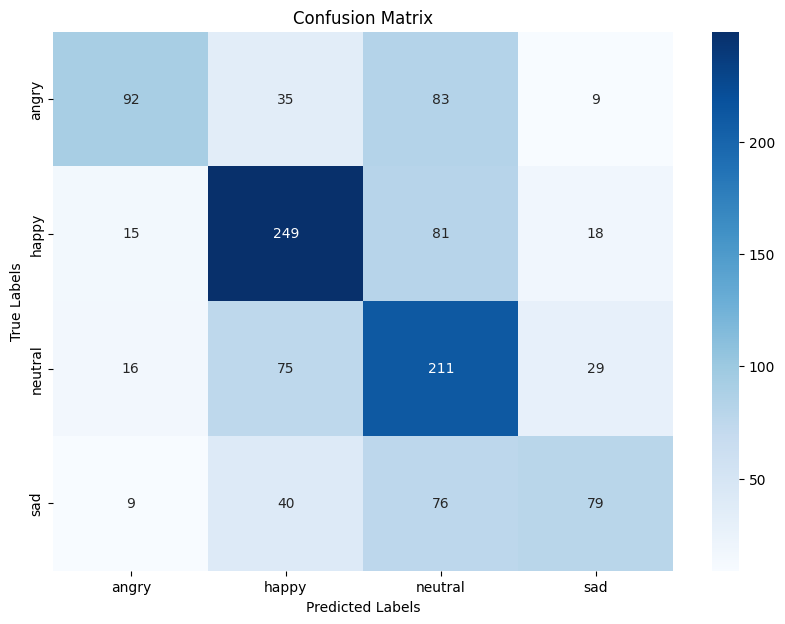

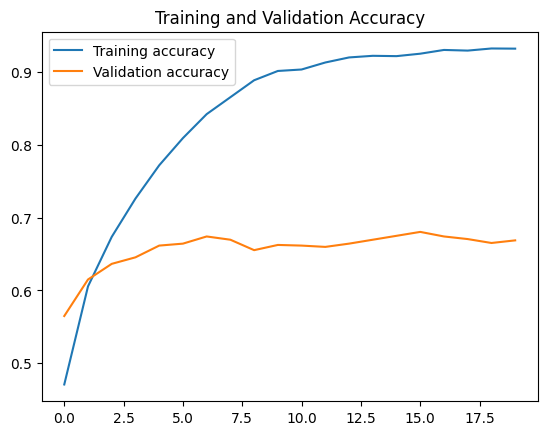

Tet Accuracy: 0.5649060010910034
F1 Score: 0.5601976442878406
Confusion Matrix:
 [[ 92  35  83   9]
 [ 15 249  81  18]
 [ 16  75 211  29]
 [  9  40  76  79]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3839 - loss: 1.2999 - val_accuracy: 0.5622 - val_loss: 1.0251
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5935 - loss: 0.9868 - val_accuracy: 0.6097 - val_loss: 0.9193
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6643 - loss: 0.8508 - val_accuracy: 0.6455 - val_loss: 0.8660
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7151 - loss: 0.7479 - val_accuracy: 0.6661 - val_loss: 0.8316
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7661 - loss: 0.6326 - val_accuracy: 0.6858 - val_loss: 0.8099
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8066 - loss: 0.5454 - val_accuracy: 0.6911 - val_loss: 0.8226
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.4544 - val_accuracy: 0.6885 - val_loss: 0.8459
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8633 - loss: 0.3773 - val_accuracy: 0.6840

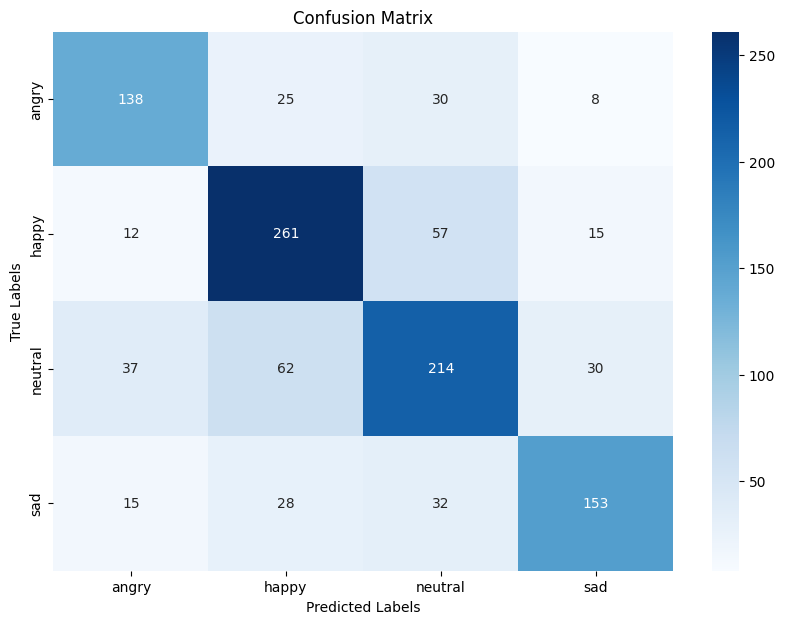

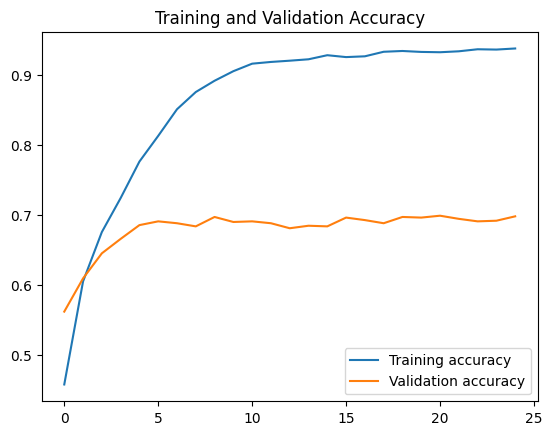

Tet Accuracy: 0.6857654452323914
F1 Score: 0.685189879204949
Confusion Matrix:
 [[138  25  30   8]
 [ 12 261  57  15]
 [ 37  62 214  30]
 [ 15  28  32 153]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3934 - loss: 1.2972 - val_accuracy: 0.5882 - val_loss: 1.0303
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5994 - loss: 0.9880 - val_accuracy: 0.6204 - val_loss: 0.9445
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6569 - loss: 0.8543 - val_accuracy: 0.6410 - val_loss: 0.8864
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7075 - loss: 0.7369 - val_accuracy: 0.6580 - val_loss: 0.8668
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7627 - loss: 0.6359 - val_accuracy: 0.6688 - val_loss: 0.8512
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8150 - loss: 0.5400 - val_accuracy: 0.6652 - val_loss: 0.8632
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8451 - loss: 0.4535 - val_accuracy: 0.6598 - val_loss: 0.9052
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8665 - loss: 0.3794 - val_accuracy: 0.6598

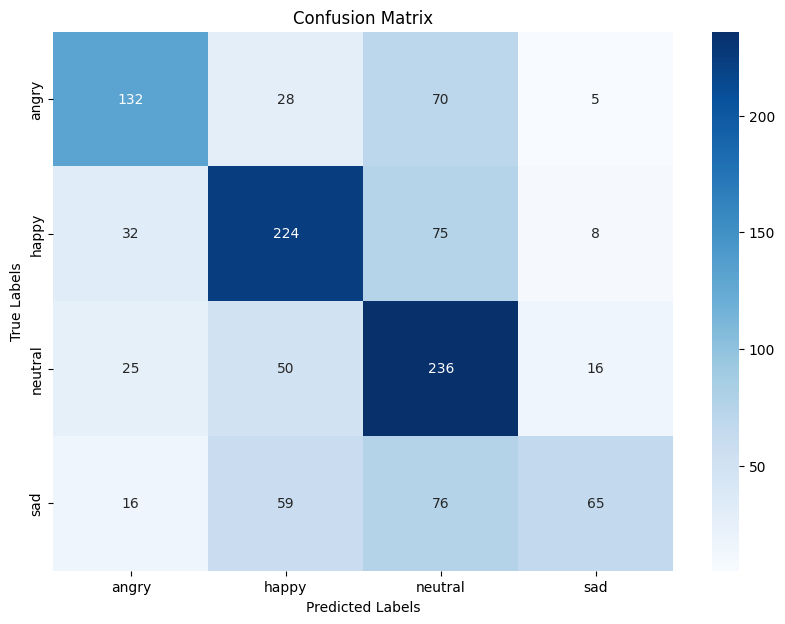

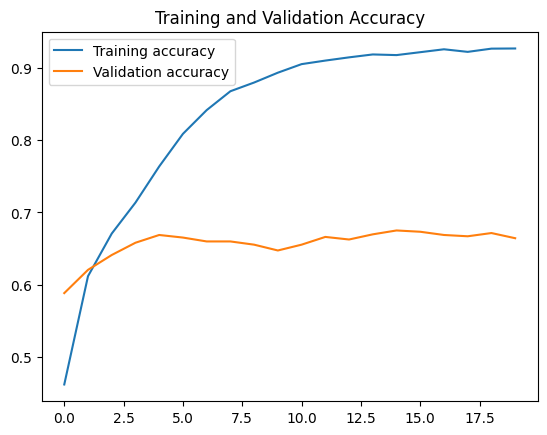

Tet Accuracy: 0.5881826281547546
F1 Score: 0.577804827305341
Confusion Matrix:
 [[132  28  70   5]
 [ 32 224  75   8]
 [ 25  50 236  16]
 [ 16  59  76  65]]
*********************************************
Average F1 Score across all folds: 0.6225915909996099
Average Accuracy across all folds: 0.625194787979126


In [52]:

def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),  # Input dimension is 384 for sBERT
        #Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')



# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


In [ ]:
Without DropOut "Average F1 Score across all folds: 0.5571513490281926
Average Accuracy across all folds: 0.5674487113952636"

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3543 - loss: 1.3383 - val_accuracy: 0.4991 - val_loss: 1.1699
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5458 - loss: 1.0965 - val_accuracy: 0.5331 - val_loss: 1.0571
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6101 - loss: 0.9477 - val_accuracy: 0.5564 - val_loss: 1.0159
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6523 - loss: 0.8725 - val_accuracy: 0.5859 - val_loss: 0.9889
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6728 - loss: 0.8097 - val_accuracy: 0.6038 - val_loss: 0.9692
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6983 - loss: 0.7517 - val_accuracy: 0.6064 - val_loss: 0.9522
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7157 - loss: 0.7026 - val_accuracy: 0.6297 - val_loss: 0.9382
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7445 - loss: 0.6517 - val_accuracy: 0.6243

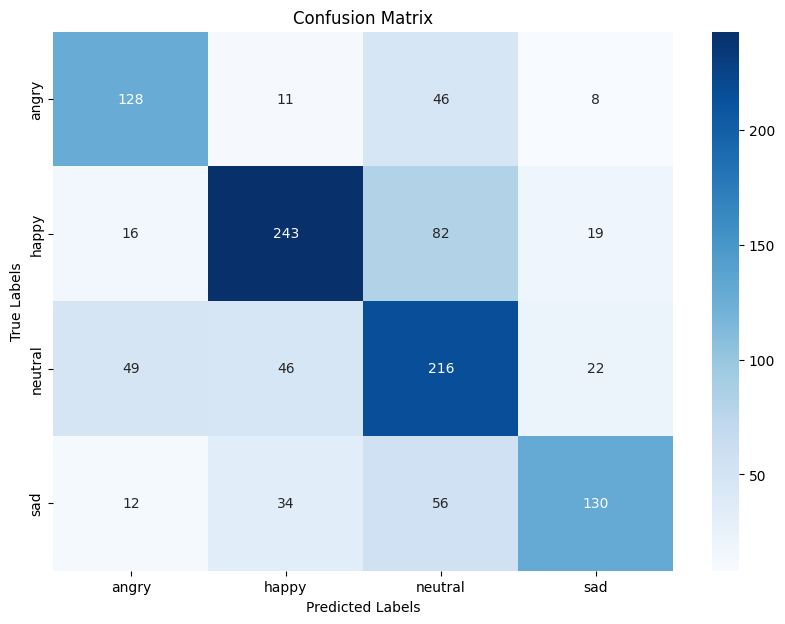

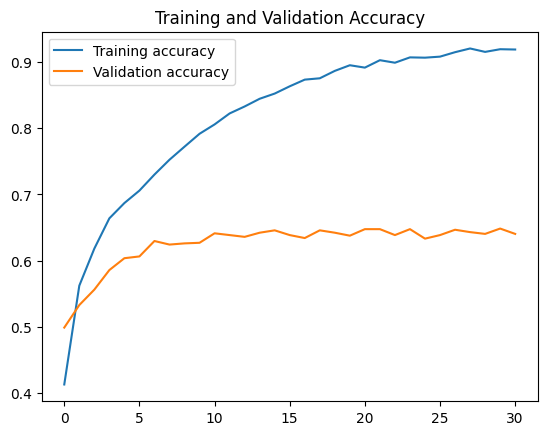

Tet Accuracy: 0.6413238048553467
F1 Score: 0.6433496604661927
Confusion Matrix:
 [[128  11  46   8]
 [ 16 243  82  19]
 [ 49  46 216  22]
 [ 12  34  56 130]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3548 - loss: 1.3375 - val_accuracy: 0.5456 - val_loss: 1.1391
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5346 - loss: 1.1117 - val_accuracy: 0.5778 - val_loss: 0.9984
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6083 - loss: 0.9746 - val_accuracy: 0.6091 - val_loss: 0.9435
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6422 - loss: 0.8824 - val_accuracy: 0.6234 - val_loss: 0.9112
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6778 - loss: 0.8086 - val_accuracy: 0.6360 - val_loss: 0.8882
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7059 - loss: 0.7511 - val_accuracy: 0.6369 - val_loss: 0.8703
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7355 - loss: 0.6944 - val_accuracy: 0.6449 - val_loss: 0.8598
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7498 - loss: 0.6426 - val_accuracy: 0.6565

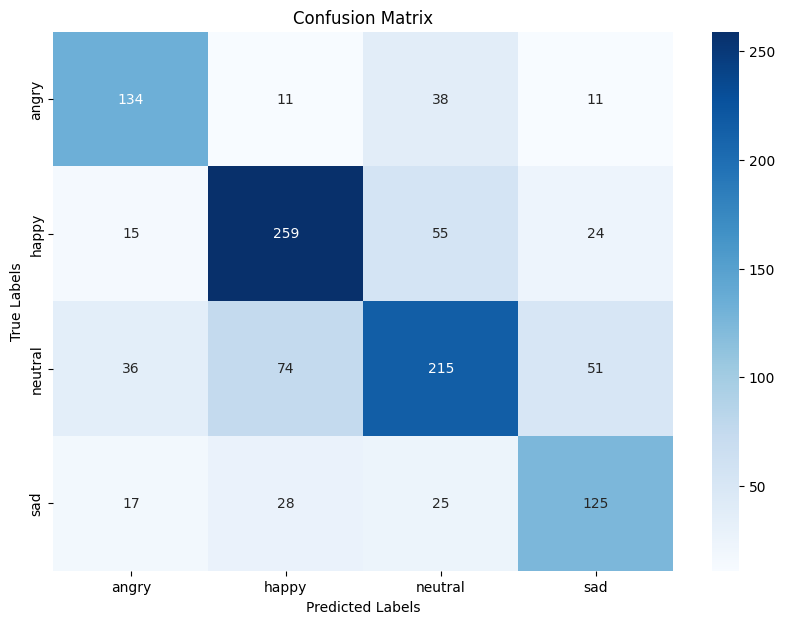

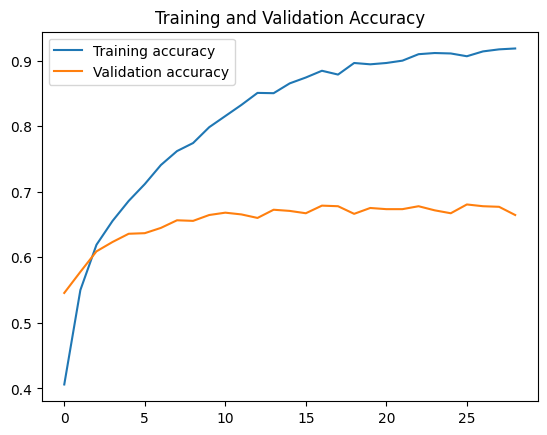

Tet Accuracy: 0.6556350588798523
F1 Score: 0.6543995768821501
Confusion Matrix:
 [[134  11  38  11]
 [ 15 259  55  24]
 [ 36  74 215  51]
 [ 17  28  25 125]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3586 - loss: 1.3422 - val_accuracy: 0.4978 - val_loss: 1.1730
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5527 - loss: 1.0958 - val_accuracy: 0.5792 - val_loss: 1.0147
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6325 - loss: 0.9331 - val_accuracy: 0.5989 - val_loss: 0.9669
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6609 - loss: 0.8546 - val_accuracy: 0.6132 - val_loss: 0.9315
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6930 - loss: 0.7901 - val_accuracy: 0.6329 - val_loss: 0.9092
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7248 - loss: 0.7243 - val_accuracy: 0.6329 - val_loss: 0.8931
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7399 - loss: 0.6659 - val_accuracy: 0.6446 - val_loss: 0.8816
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7651 - loss: 0.6221 - val_accuracy: 0.6580

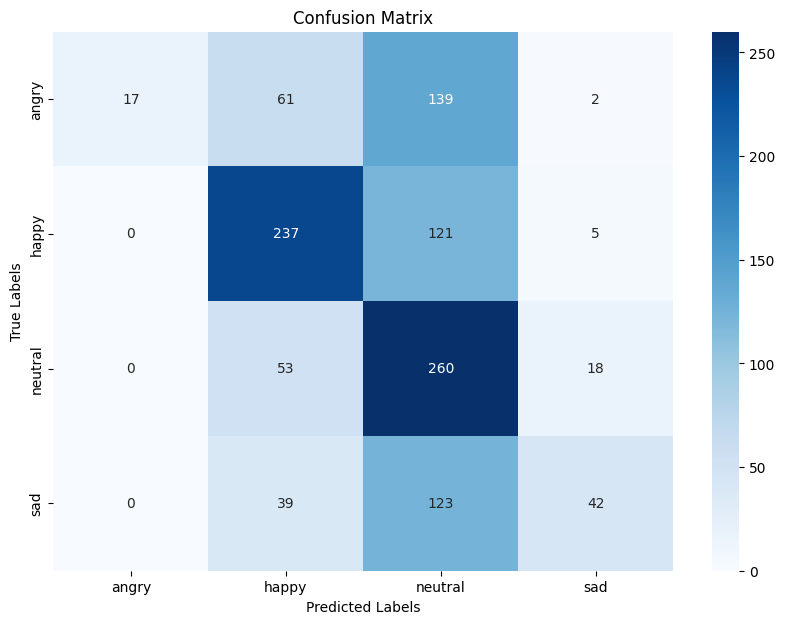

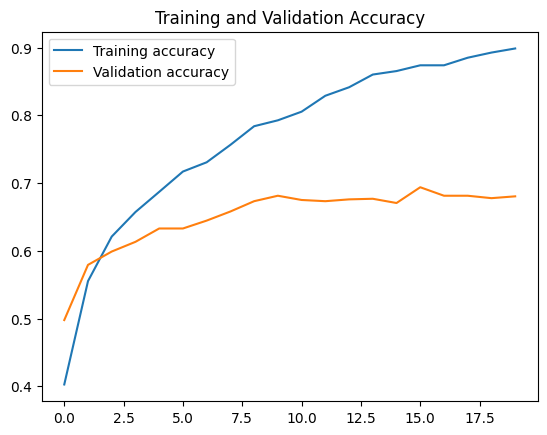

Tet Accuracy: 0.49776187539100647
F1 Score: 0.44762747615905485
Confusion Matrix:
 [[ 17  61 139   2]
 [  0 237 121   5]
 [  0  53 260  18]
 [  0  39 123  42]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3513 - loss: 1.3426 - val_accuracy: 0.5157 - val_loss: 1.1678
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5426 - loss: 1.1086 - val_accuracy: 0.5730 - val_loss: 1.0014
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5997 - loss: 0.9610 - val_accuracy: 0.6124 - val_loss: 0.9392
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6304 - loss: 0.8884 - val_accuracy: 0.6285 - val_loss: 0.9064
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6658 - loss: 0.8199 - val_accuracy: 0.6428 - val_loss: 0.8764
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7018 - loss: 0.7529 - val_accuracy: 0.6580 - val_loss: 0.8529
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7296 - loss: 0.7059 - val_accuracy: 0.6652 - val_loss: 0.8331
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7611 - loss: 0.6464 - val_accuracy: 0.6741

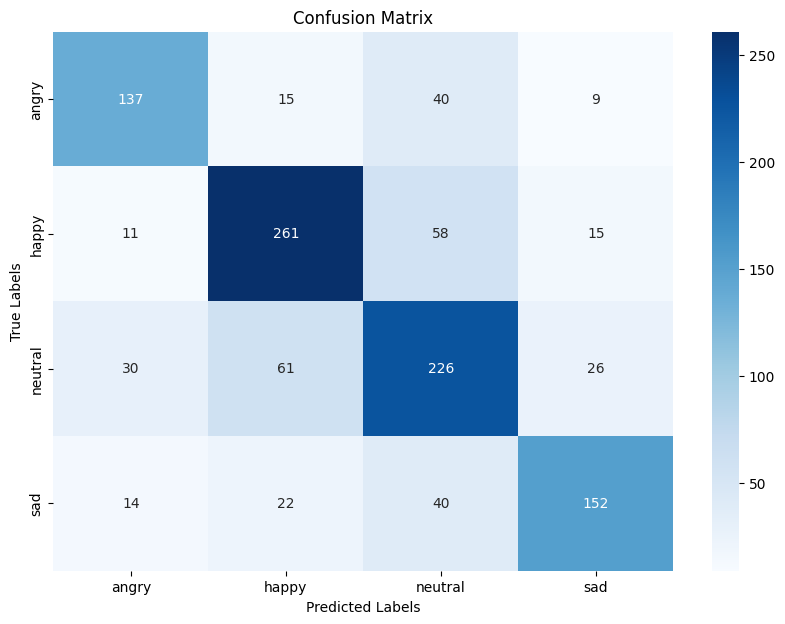

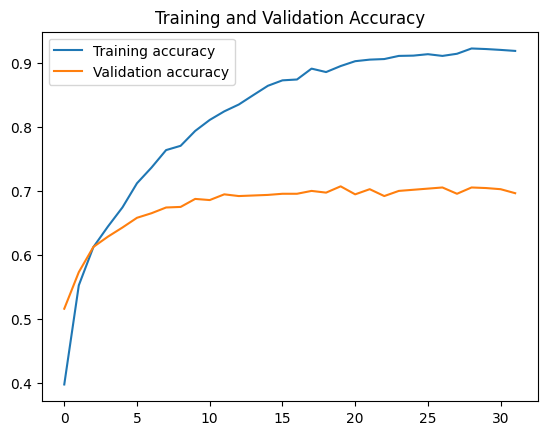

Tet Accuracy: 0.6947180032730103
F1 Score: 0.6950983796404223
Confusion Matrix:
 [[137  15  40   9]
 [ 11 261  58  15]
 [ 30  61 226  26]
 [ 14  22  40 152]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3644 - loss: 1.3319 - val_accuracy: 0.5067 - val_loss: 1.1624
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5362 - loss: 1.1038 - val_accuracy: 0.5927 - val_loss: 1.0040
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5964 - loss: 0.9645 - val_accuracy: 0.6132 - val_loss: 0.9535
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6416 - loss: 0.8937 - val_accuracy: 0.6240 - val_loss: 0.9214
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6746 - loss: 0.8249 - val_accuracy: 0.6401 - val_loss: 0.9006
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7110 - loss: 0.7612 - val_accuracy: 0.6473 - val_loss: 0.8825
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7403 - loss: 0.7029 - val_accuracy: 0.6553 - val_loss: 0.8729
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7517 - loss: 0.6524 - val_accuracy: 0.6616

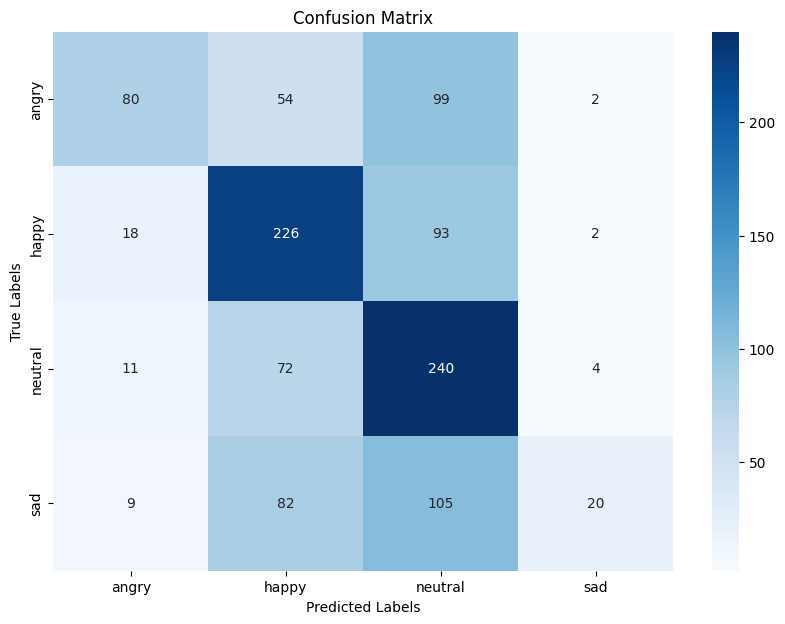

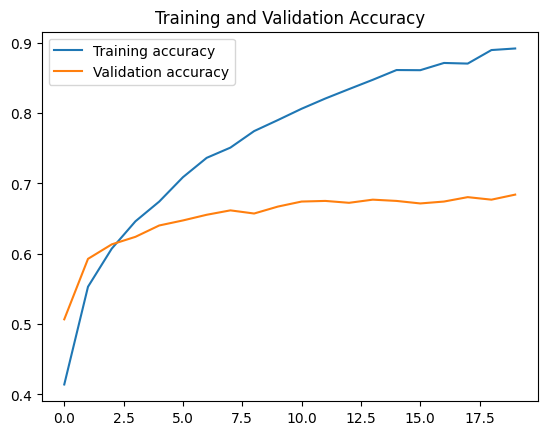

Tet Accuracy: 0.506714403629303
F1 Score: 0.46715951700390684
Confusion Matrix:
 [[ 80  54  99   2]
 [ 18 226  93   2]
 [ 11  72 240   4]
 [  9  82 105  20]]
*********************************************
Average F1 Score across all folds: 0.5815269220303454
Average Accuracy across all folds: 0.5992306292057037


In [53]:
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.3),  # Adjusted dropout
        Dense(128, activation='relu'),
        Dropout(0.3),  # Adjusted dropout
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),  # Adjusted learning rate
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')



# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')

# Doing Grid Search

In [57]:
! pip install scikeras


In [58]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def build_model(dropout_rate=0.5, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(output_size, activation='softmax')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Using verbose=1 for KerasClassifier to show progress for each epoch
model = KerasClassifier(model=build_model, dropout_rate=0.5, optimizer='adam', learning_rate=0.001, batch_size=32, epochs=100, verbose=1)

param_grid = {
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'model__optimizer': ['adam', 'sgd'],
    'model__learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Using verbose=2 for GridSearchCV to show messages for each fit of the model
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)
grid_result = grid.fit(X, y)  # X and y should be pre-defined data and labels

# Print the best parameters and the best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3278 - loss: 1.3507
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4617 - loss: 1.2104
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5353 - loss: 1.0896
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5693 - loss: 1.0158
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6153 - loss: 0.9447
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6360 - loss: 0.9154
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6542 - loss: 0.8691
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6657 - loss: 0.8478
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6932 - loss: 0.7883
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6982 - loss: 0.7571
Epoch 11/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7138 - loss: 0.7461
Epoch 12/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

# Using values from Grid Search

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4365 - loss: 1.2613 - val_accuracy: 0.5805 - val_loss: 1.0015
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 0.9095 - val_accuracy: 0.6324 - val_loss: 0.9298
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6946 - loss: 0.7588 - val_accuracy: 0.6530 - val_loss: 0.8989
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7577 - loss: 0.6342 - val_accuracy: 0.6682 - val_loss: 0.8935
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8071 - loss: 0.5187 - val_accuracy: 0.6619 - val_loss: 0.9179
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8488 - loss: 0.4194 - val_accuracy: 0.6691 - val_loss: 0.9616
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8862 - loss: 0.3408 - val_accuracy: 0.6646 - val_loss: 1.0209
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9013 - loss: 0.2894 - val_accuracy: 0.6547

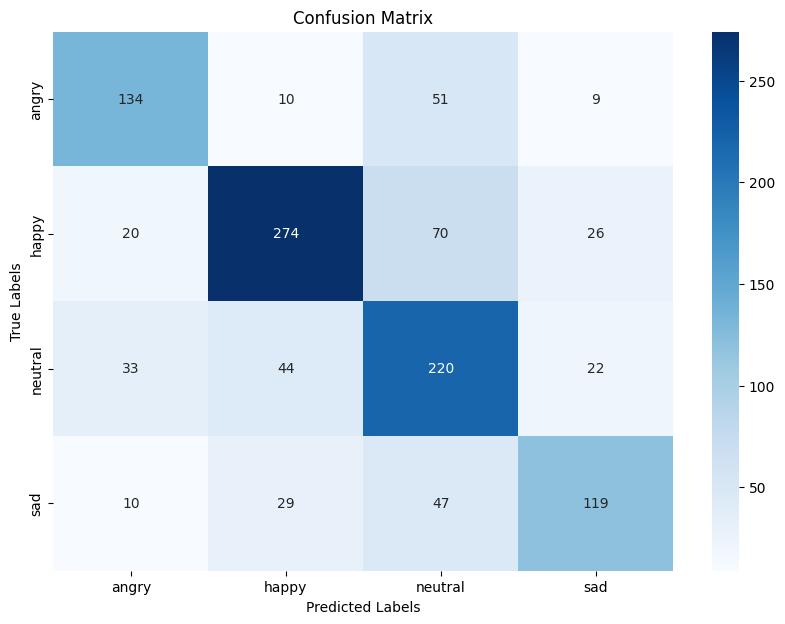

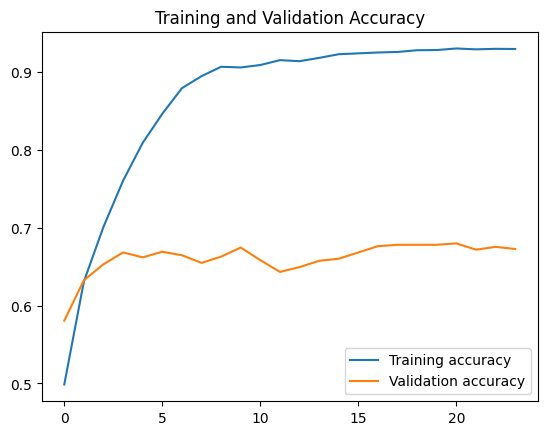

Tet Accuracy: 0.6681573987007141
F1 Score: 0.6699734421549679
Confusion Matrix:
 [[134  10  51   9]
 [ 20 274  70  26]
 [ 33  44 220  22]
 [ 10  29  47 119]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4147 - loss: 1.2647 - val_accuracy: 0.6145 - val_loss: 0.9745
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6091 - loss: 0.9333 - val_accuracy: 0.6342 - val_loss: 0.9161
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6821 - loss: 0.7828 - val_accuracy: 0.6619 - val_loss: 0.8978
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7415 - loss: 0.6468 - val_accuracy: 0.6619 - val_loss: 0.9023
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8099 - loss: 0.5229 - val_accuracy: 0.6762 - val_loss: 0.9311
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8501 - loss: 0.4183 - val_accuracy: 0.6744 - val_loss: 0.9781
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8833 - loss: 0.3383 - val_accuracy: 0.6744 - val_loss: 1.0248
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9032 - loss: 0.2868 - val_accuracy: 0.6735

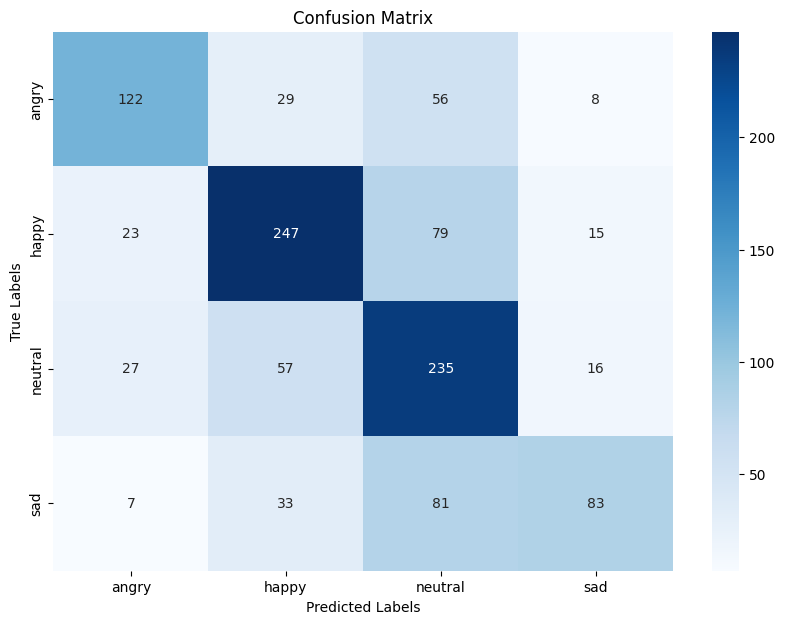

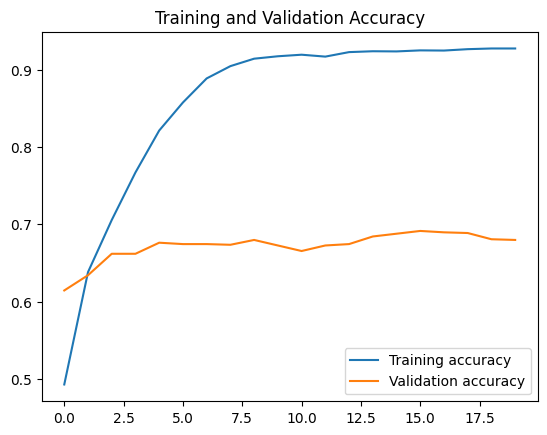

Tet Accuracy: 0.6144901514053345
F1 Score: 0.6115079271594973
Confusion Matrix:
 [[122  29  56   8]
 [ 23 247  79  15]
 [ 27  57 235  16]
 [  7  33  81  83]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4048 - loss: 1.2533 - val_accuracy: 0.5819 - val_loss: 0.9797
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6409 - loss: 0.8876 - val_accuracy: 0.6168 - val_loss: 0.9213
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7092 - loss: 0.7429 - val_accuracy: 0.6294 - val_loss: 0.8975
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7729 - loss: 0.6199 - val_accuracy: 0.6446 - val_loss: 0.8897
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8206 - loss: 0.5055 - val_accuracy: 0.6509 - val_loss: 0.9032
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8615 - loss: 0.4071 - val_accuracy: 0.6553 - val_loss: 0.9416
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8958 - loss: 0.3296 - val_accuracy: 0.6553 - val_loss: 0.9972
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9069 - loss: 0.2752 - val_accuracy: 0.6562

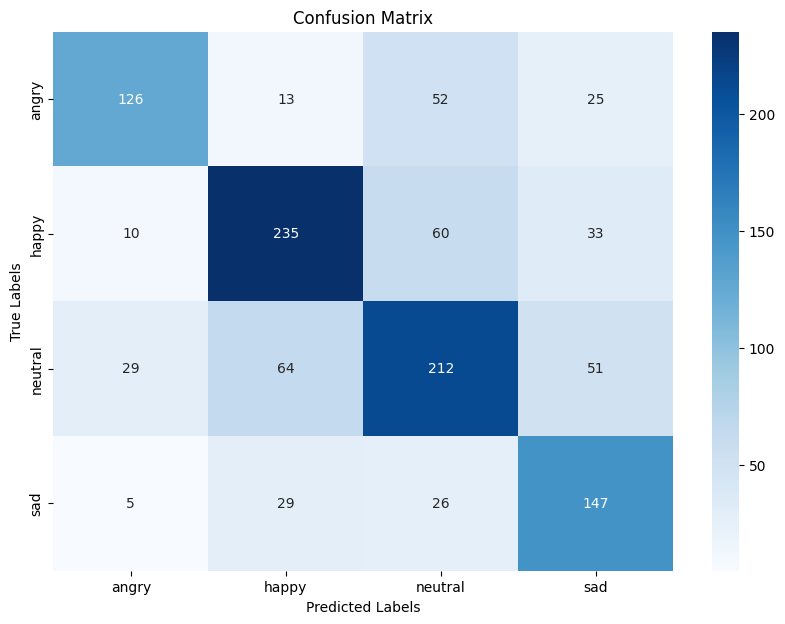

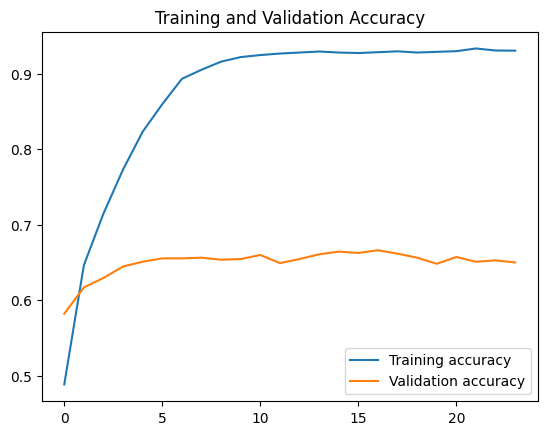

Tet Accuracy: 0.6445837020874023
F1 Score: 0.6447821994016978
Confusion Matrix:
 [[126  13  52  25]
 [ 10 235  60  33]
 [ 29  64 212  51]
 [  5  29  26 147]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4532 - loss: 1.2513 - val_accuracy: 0.5380 - val_loss: 1.0604
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6321 - loss: 0.9126 - val_accuracy: 0.5819 - val_loss: 0.9898
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6878 - loss: 0.7739 - val_accuracy: 0.6088 - val_loss: 0.9477
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7528 - loss: 0.6527 - val_accuracy: 0.6419 - val_loss: 0.9280
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8085 - loss: 0.5395 - val_accuracy: 0.6500 - val_loss: 0.9279
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.4361 - val_accuracy: 0.6652 - val_loss: 0.9512
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8826 - loss: 0.3549 - val_accuracy: 0.6616 - val_loss: 0.9949
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9050 - loss: 0.2990 - val_accuracy: 0.6571

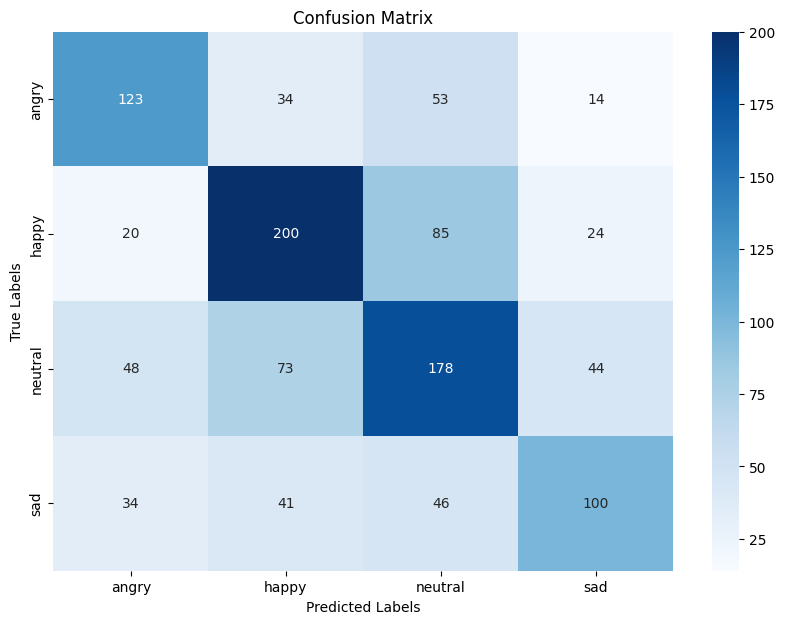

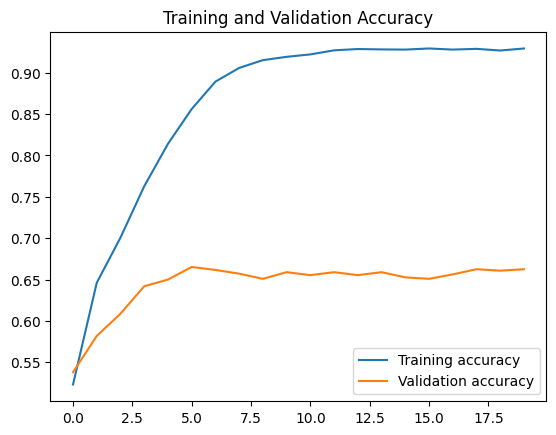

Tet Accuracy: 0.5380483269691467
F1 Score: 0.5371471044027172
Confusion Matrix:
 [[123  34  53  14]
 [ 20 200  85  24]
 [ 48  73 178  44]
 [ 34  41  46 100]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4287 - loss: 1.2566 - val_accuracy: 0.6007 - val_loss: 0.9708
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6273 - loss: 0.9103 - val_accuracy: 0.6338 - val_loss: 0.8801
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6908 - loss: 0.7665 - val_accuracy: 0.6580 - val_loss: 0.8303
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7411 - loss: 0.6441 - val_accuracy: 0.6867 - val_loss: 0.8040
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.5315 - val_accuracy: 0.6938 - val_loss: 0.8037
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8477 - loss: 0.4344 - val_accuracy: 0.6974 - val_loss: 0.8275
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.3576 - val_accuracy: 0.6965 - val_loss: 0.8702
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8993 - loss: 0.2998 - val_accuracy: 0.6876

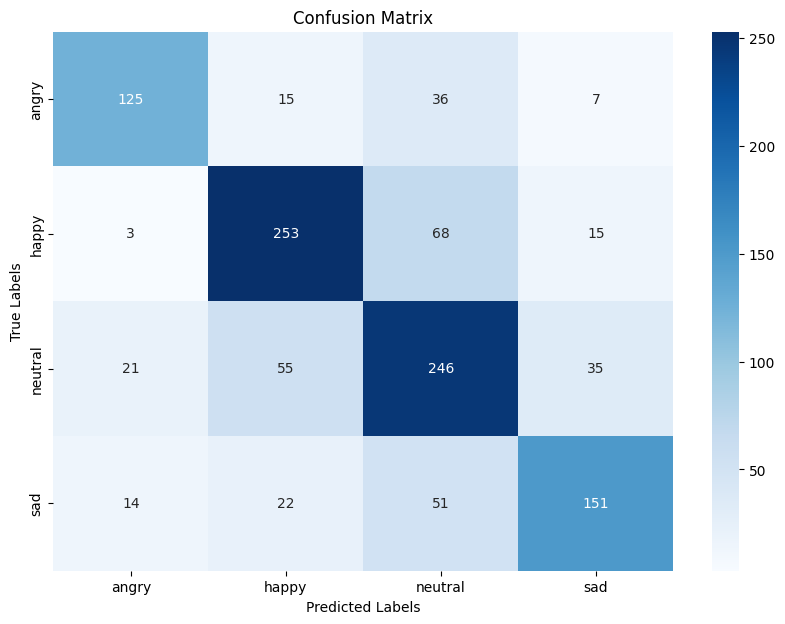

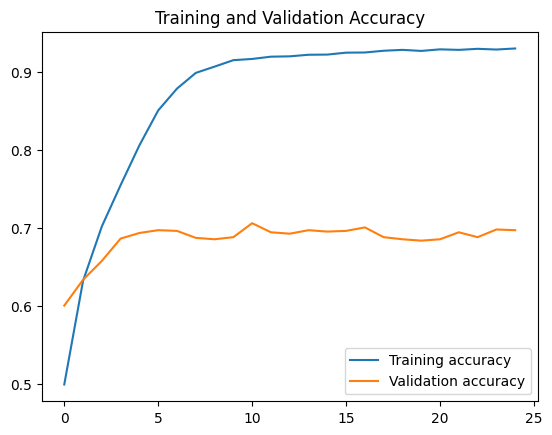

Tet Accuracy: 0.6938227415084839
F1 Score: 0.694613610184185
Confusion Matrix:
 [[125  15  36   7]
 [  3 253  68  15]
 [ 21  55 246  35]
 [ 14  22  51 151]]
*********************************************
Average F1 Score across all folds: 0.6316048566606131
Average Accuracy across all folds: 0.6318204641342163


In [60]:
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        #Dropout(0.7),  # Adjusted dropout
        Dense(128, activation='relu'),
        #Dropout(0.7),  # Adjusted dropout
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),  # Adjusted learning rate
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=123)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')



# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')

# Dealing whith imbalanced class

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/175 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training fold 1
Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2912 - loss: 1.3735 - val_accuracy: 0.4928 - val_loss: 1.2794
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4306 - loss: 1.2610 - val_accuracy: 0.5018 - val_loss: 1.1207
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5198 - loss: 1.1146 - val_accuracy: 0.5277 - val_loss: 1.0471
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5534 - loss: 1.0411 - val_accuracy: 0.5572 - val_loss: 1.0160
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5833 - loss: 0.9550 - val_accuracy: 0.5725 - val_loss: 0.9927
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6140 - loss: 0.9057 - val_accuracy: 0.5805 - val_loss: 0.9674
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6459 - loss: 0.8666 - val_accuracy: 0.5957 - val_loss: 0.9549
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6525 - loss: 0

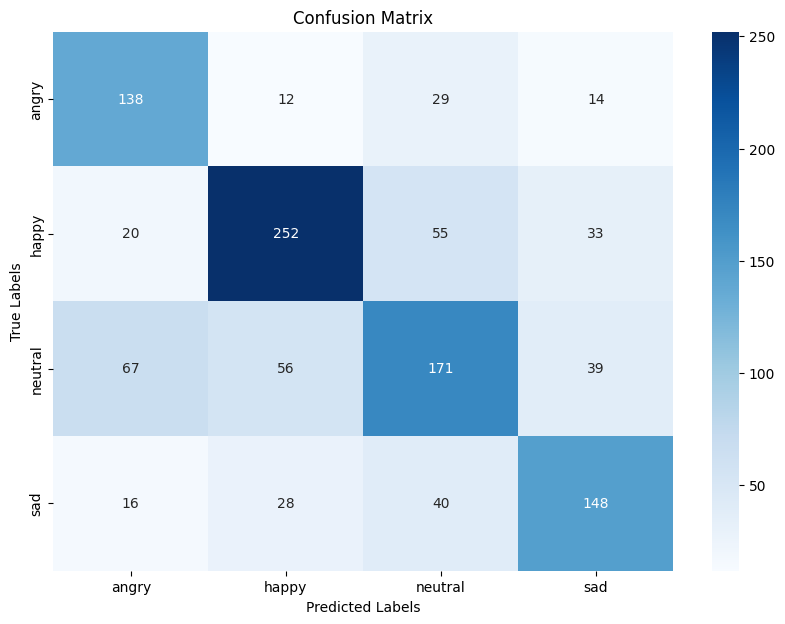

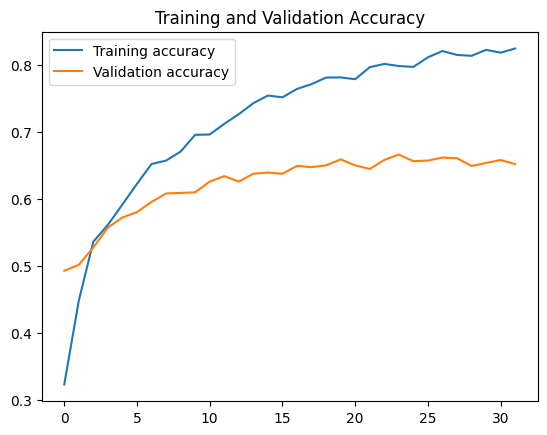

Test Accuracy: 0.6341681480407715
F1 Score: 0.6330236621239111
Confusion Matrix:
 [[138  12  29  14]
 [ 20 252  55  33]
 [ 67  56 171  39]
 [ 16  28  40 148]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3081 - loss: 1.3779 - val_accuracy: 0.4955 - val_loss: 1.2756
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4461 - loss: 1.2511 - val_accuracy: 0.5394 - val_loss: 1.0974
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5171 - loss: 1.1204 - val_accuracy: 0.5635 - val_loss: 1.0304
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5556 - loss: 1.0549 - val_accuracy: 0.5912 - val_loss: 0.9757
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5954 - loss: 0.9781 - val_accuracy: 0.6038 - val_loss: 0.9439
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6243 - loss: 0.9160 - val_accuracy: 0.6208 - val_loss: 0.9161
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6379 - loss: 0.8866 - val_accuracy: 0.6351 - val_loss: 0.9031
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6702 - loss: 0.8318 - val_accuracy: 0.6395

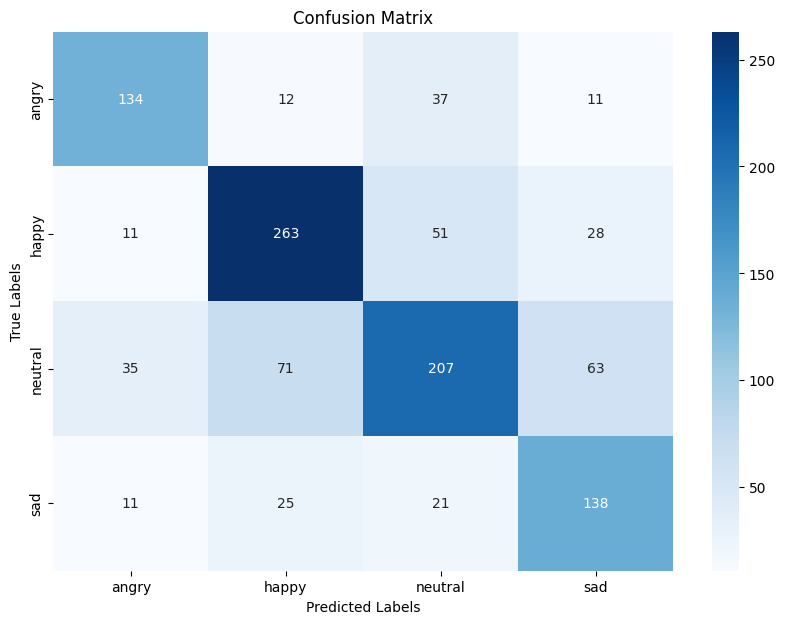

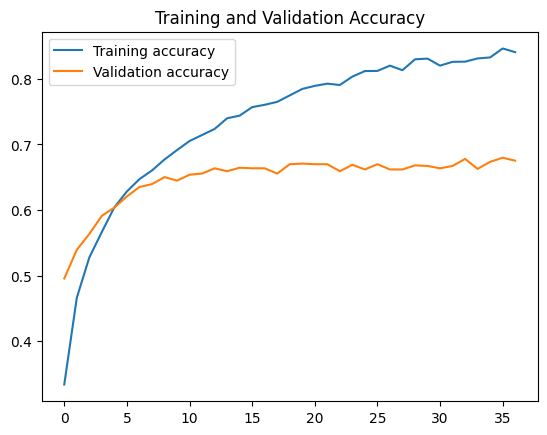

Test Accuracy: 0.663685142993927
F1 Score: 0.6620550953673112
Confusion Matrix:
 [[134  12  37  11]
 [ 11 263  51  28]
 [ 35  71 207  63]
 [ 11  25  21 138]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2753 - loss: 1.3814 - val_accuracy: 0.4996 - val_loss: 1.2922
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4283 - loss: 1.2689 - val_accuracy: 0.5470 - val_loss: 1.0916
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5124 - loss: 1.1108 - val_accuracy: 0.5783 - val_loss: 1.0124
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5849 - loss: 1.0220 - val_accuracy: 0.5918 - val_loss: 0.9805
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6168 - loss: 0.9487 - val_accuracy: 0.5989 - val_loss: 0.9567
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6291 - loss: 0.8945 - val_accuracy: 0.6124 - val_loss: 0.9247
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6388 - loss: 0.8556 - val_accuracy: 0.6240 - val_loss: 0.9011
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6658 - loss: 0.8208 - val_accuracy: 0.6401

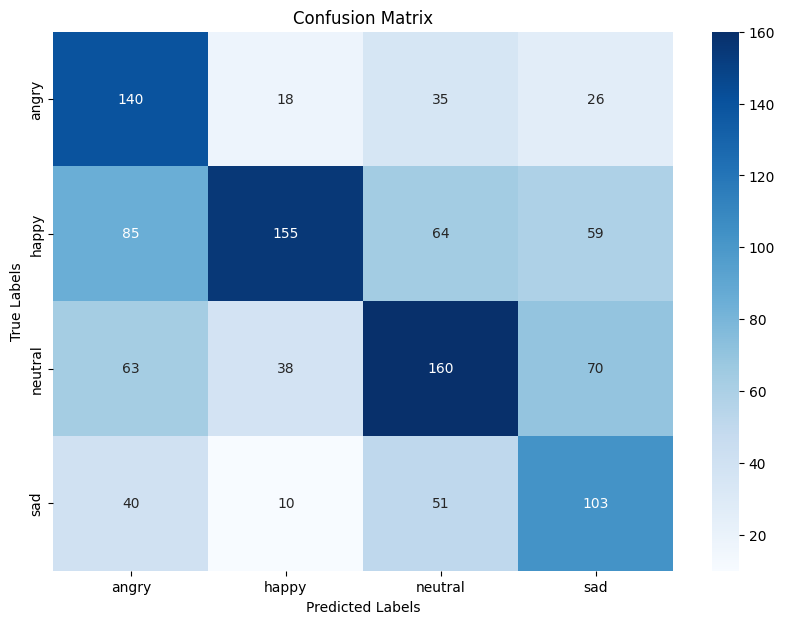

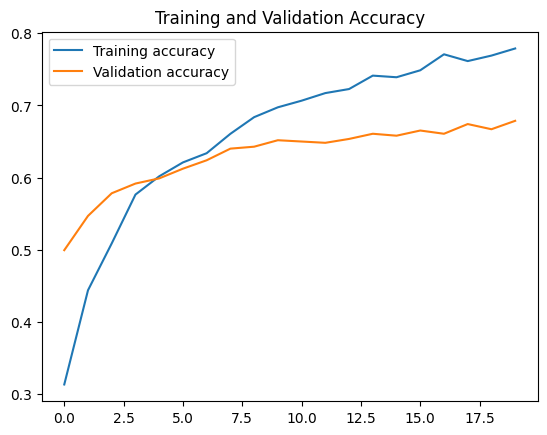

Test Accuracy: 0.4995523691177368
F1 Score: 0.5022323915823131
Confusion Matrix:
 [[140  18  35  26]
 [ 85 155  64  59]
 [ 63  38 160  70]
 [ 40  10  51 103]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2888 - loss: 1.3801 - val_accuracy: 0.5264 - val_loss: 1.2729
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4298 - loss: 1.2658 - val_accuracy: 0.5452 - val_loss: 1.0960
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 1.1125 - val_accuracy: 0.5694 - val_loss: 1.0086
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5485 - loss: 1.0619 - val_accuracy: 0.5944 - val_loss: 0.9671
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5965 - loss: 0.9860 - val_accuracy: 0.6106 - val_loss: 0.9360
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6210 - loss: 0.9382 - val_accuracy: 0.6204 - val_loss: 0.9090
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6401 - loss: 0.8779 - val_accuracy: 0.6401 - val_loss: 0.8836
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6466 - loss: 0.8422 - val_accuracy: 0.6455

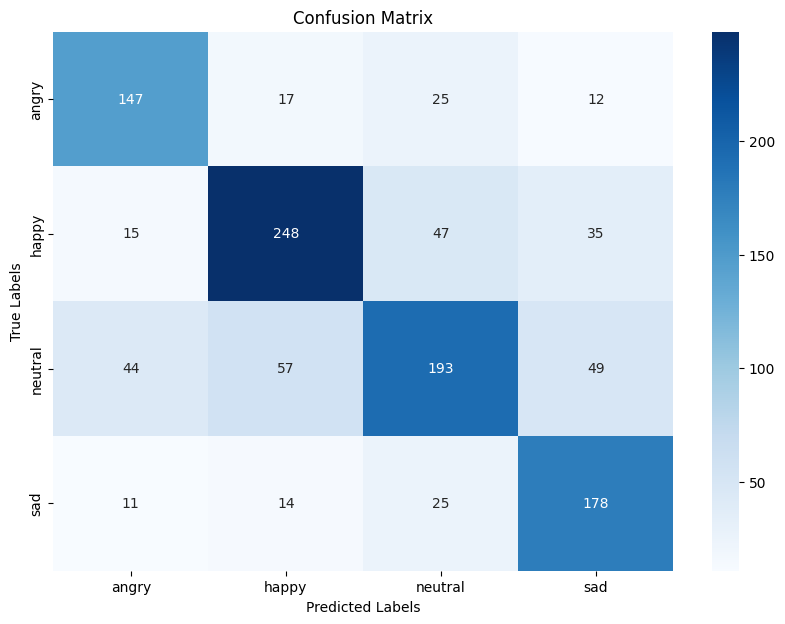

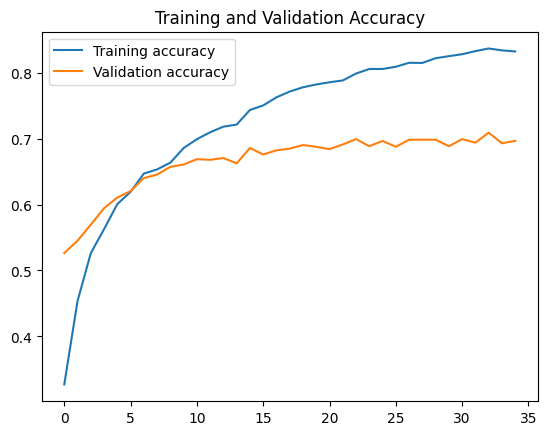

Test Accuracy: 0.6857654452323914
F1 Score: 0.6835268929911282
Confusion Matrix:
 [[147  17  25  12]
 [ 15 248  47  35]
 [ 44  57 193  49]
 [ 11  14  25 178]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2805 - loss: 1.3808 - val_accuracy: 0.5354 - val_loss: 1.2845
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4346 - loss: 1.2719 - val_accuracy: 0.5372 - val_loss: 1.1116
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5075 - loss: 1.1322 - val_accuracy: 0.5756 - val_loss: 1.0229
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5488 - loss: 1.0431 - val_accuracy: 0.5900 - val_loss: 0.9772
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5725 - loss: 0.9930 - val_accuracy: 0.6016 - val_loss: 0.9406
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6180 - loss: 0.9337 - val_accuracy: 0.6213 - val_loss: 0.9202
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6383 - loss: 0.8698 - val_accuracy: 0.6258 - val_loss: 0.9067
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6539 - loss: 0.8332 - val_accuracy: 0.6410

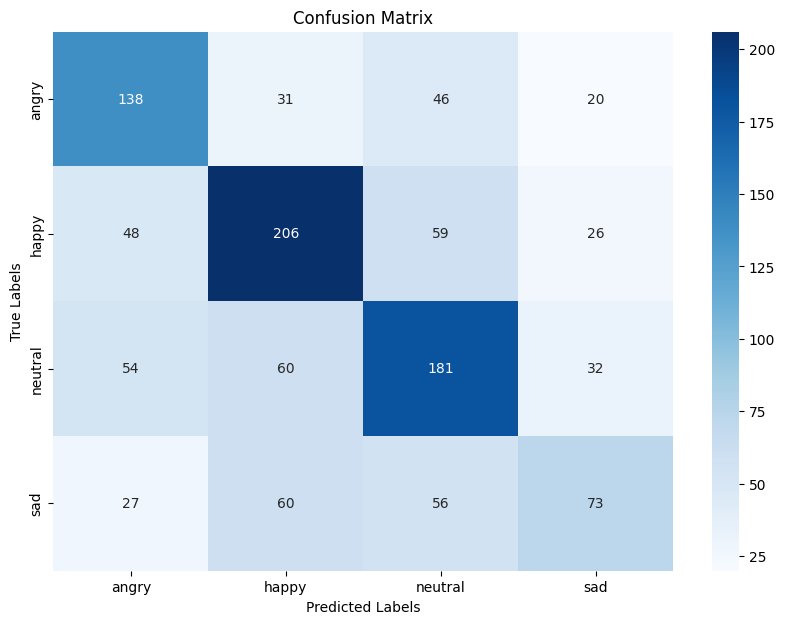

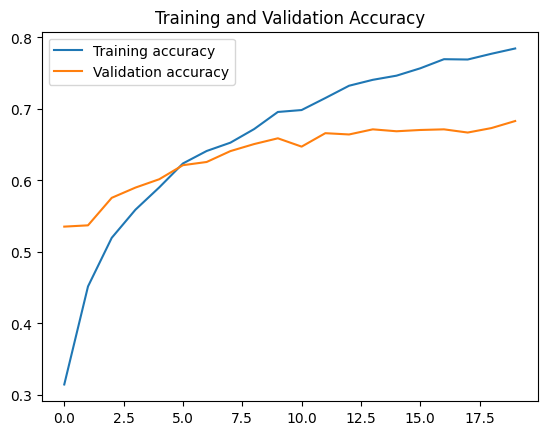

Test Accuracy: 0.5353626012802124
F1 Score: 0.5306593199582144
Confusion Matrix:
 [[138  31  46  20]
 [ 48 206  59  26]
 [ 54  60 181  32]
 [ 27  60  56  73]]
*********************************************
Average F1 Score across all folds: 0.6022994724045756
Average Accuracy across all folds: 0.6037067413330078


In [55]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load and encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding
output_size = len(encoder.classes_)

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
transcripts = merged_df['Transcript'].tolist()
embeddings = model.encode(transcripts, show_progress_bar=True)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.7),  # Adjusted dropout
        Dense(128, activation='relu'),
        Dropout(0.7),  # Adjusted dropout
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),  # Adjusted learning rate
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, class_weight=class_weights_dict, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Test Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no += 1
    print('*********************************************')

# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


In [ ]:
class_weights_dict

{0: 1.8605242566510172,
 1: 1.0311144839549002,
 2: 1.0442468159859464,
 3: 0.6514383561643836}

In [ ]:

from imblearn.over_sampling import SMOTE


# Load SentenceTransformer model and generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
transcripts = merged_df['Transcript'].tolist()
embeddings = model.encode(transcripts, show_progress_bar=True)

# Label encoding and convert to one-hot
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)
output_size = len(encoder.classes_)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

# Apply SMOTE to generate synthetic samples for balancing the dataset
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.argmax(axis=1))
y_train_res = tf.keras.utils.to_categorical(y_train_res)  # Convert labels back to categorical

# Define the model architecture
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.7),
        Dense(128, activation='relu'),
        Dropout(0.7),
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training the model with K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []

for train_index, test_index in kf.split(X_train_res):
    X_train_kf, X_test_kf = X_train_res[train_index], X_train_res[test_index]
    y_train_kf, y_test_kf = y_train_res[train_index], y_train_res[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(X_train_kf, y_train_kf, epochs=100, validation_data=(X_test_kf, y_test_kf), batch_size=32)#, callbacks=[early_stopping])

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test_kf), axis=1)
    y_true = np.argmax(y_test_kf, axis=1)
    test_acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    accuracies.append(test_acc)
    f1_scores.append(f1)
    print("Test Accuracy:", test_acc)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    fold_no += 1
    print('*********************************************')

# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3050 - loss: 1.3623 - val_accuracy: 0.5086 - val_loss: 1.1633
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4661 - loss: 1.1788 - val_accuracy: 0.5647 - val_loss: 1.0513
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5258 - loss: 1.0945 - val_accuracy: 0.5971 - val_loss: 0.9817
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5765 - loss: 1.0212 - val_accuracy: 0.6292 - val_loss: 0.9278
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5982 - loss: 0.9732 - val_accuracy: 0.6448 - val_loss: 0.8827
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6165 - loss: 0.9101 - val_accuracy: 0.6629 - val_loss: 0.8486
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6459 - loss: 0.8693 - val_accuracy: 0.6671 - val_loss: 0.8398
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6580 - loss: 0.8474 - val_accuracy: 0.679

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3148 - loss: 1.3583 - val_accuracy: 0.5086 - val_loss: 1.1492
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4743 - loss: 1.1803 - val_accuracy: 0.5563 - val_loss: 1.0531
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5372 - loss: 1.0790 - val_accuracy: 0.5946 - val_loss: 0.9743
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5629 - loss: 1.0102 - val_accuracy: 0.6153 - val_loss: 0.9297
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6008 - loss: 0.9599 - val_accuracy: 0.6401 - val_loss: 0.8863
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6296 - loss: 0.9087 - val_accuracy: 0.6578 - val_loss: 0.8465
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6376 - loss: 0.8890 - val_accuracy: 0.6789 - val_loss: 0.8235
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6671 - loss: 0.8335 - val_accuracy: 0.6839

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3248 - loss: 1.3557 - val_accuracy: 0.4707 - val_loss: 1.1714
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4767 - loss: 1.1705 - val_accuracy: 0.5306 - val_loss: 1.0716
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5291 - loss: 1.0895 - val_accuracy: 0.5697 - val_loss: 1.0080
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5707 - loss: 1.0060 - val_accuracy: 0.5904 - val_loss: 0.9565
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6045 - loss: 0.9530 - val_accuracy: 0.6203 - val_loss: 0.9131
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6306 - loss: 0.9093 - val_accuracy: 0.6405 - val_loss: 0.8800
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6423 - loss: 0.8774 - val_accuracy: 0.6599 - val_loss: 0.8496
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6573 - loss: 0.8508 - val_accuracy: 0.6717

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3077 - loss: 1.3637 - val_accuracy: 0.5023 - val_loss: 1.1601
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4853 - loss: 1.1713 - val_accuracy: 0.5411 - val_loss: 1.0490
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5341 - loss: 1.0819 - val_accuracy: 0.5765 - val_loss: 0.9782
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5684 - loss: 1.0184 - val_accuracy: 0.6136 - val_loss: 0.9195
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6017 - loss: 0.9526 - val_accuracy: 0.6275 - val_loss: 0.8815
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6214 - loss: 0.9256 - val_accuracy: 0.6464 - val_loss: 0.8551
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6508 - loss: 0.8679 - val_accuracy: 0.6734 - val_loss: 0.8271
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6729 - loss: 0.8307 - val_accuracy: 0.686

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3055 - loss: 1.3612 - val_accuracy: 0.4916 - val_loss: 1.1569
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4795 - loss: 1.1723 - val_accuracy: 0.5489 - val_loss: 1.0579
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5329 - loss: 1.0860 - val_accuracy: 0.5725 - val_loss: 1.0010
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5720 - loss: 1.0127 - val_accuracy: 0.6079 - val_loss: 0.9507
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5910 - loss: 0.9579 - val_accuracy: 0.6324 - val_loss: 0.9068
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6270 - loss: 0.9078 - val_accuracy: 0.6471 - val_loss: 0.8756
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6495 - loss: 0.8558 - val_accuracy: 0.6526 - val_loss: 0.8603
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6628 - loss: 0.8288 - val_accuracy: 0.65

Average F1 Score across all folds: 0.740423011658815
Average Accuracy across all folds: 0.7417396312790963